In [104]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
import sys
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib import patches
from matplotlib.collections import PatchCollection
#import matplotlib
from PIL import Image, ImageDraw
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import threshold_otsu
from shapely.geometry.polygon import Polygon as Polygon_shapley
# from multiprocessing import Pool
import multiprocessing
import time
import random
import pickle
import png
from scipy.spatial import ConvexHull
import bbox_visualizer as bbv
import operator
import fileinput
import re
sys.path.insert(0, os.path.dirname(os.path.abspath('.'))) # to make imports relative to project root work

# Check Cell Images Malaria Dataset

Get data from https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets save it in data

In [77]:
path_uninfected = '../data/cell_images/patientid_cellmapping_uninfected.csv'
path_parasitized = '../data/cell_images/patientid_cellmapping_parasitized.csv'
# Read in the file
with open(path_uninfected, 'r') as file :
    filedata = file.read()

# Replace the target string
filedata = filedata.replace('[|]', '')

# Write the file out again
with open(path_uninfected, 'w') as file:
    file.write(filedata)


In [78]:
#read and transform data
uninfected = pd.read_csv('../data/cell_images/patientid_cellmapping_uninfected.csv', header = None)
uninfected = uninfected.set_index(0)
uninfected['imgs'] = uninfected.values.tolist()
uninfected['imgs'] = uninfected['imgs'].apply(lambda mylist: [x for x in mylist if pd.isnull(x) == False])
uninfected_df = pd.DataFrame(uninfected['imgs'], index =uninfected.index)
parasitized = pd.read_csv('../data/cell_images/patientid_cellmapping_parasitized.csv', header = None)
parasitized = parasitized.set_index(0)
parasitized['imgs'] = parasitized.values.tolist()
parasitized['imgs'] = parasitized['imgs'].apply(lambda mylist: [x for x in mylist if pd.isnull(x) == False])
parasitized_df = pd.DataFrame(parasitized['imgs'], index =parasitized.index)

In [140]:
# get additional data
uninfected_df['len_imgs'] = uninfected_df['imgs'].apply(lambda x: len(x))
parasitized_df['len_imgs'] = parasitized_df['imgs'].apply(lambda x: len(x))
uninfected_df

imgs  len_imgs  \
0                                                                           
C100P61ThinF  ['C100P61ThinF_IMG_20150918_144104_cell_128.pn...        68   
C101P62ThinF  ['C101P62ThinF_IMG_20150918_151006_cell_17.png...        71   
C102P63ThinF  ['C102P63ThinF_IMG_20150918_161508_cell_101.pn...        68   
C103P64ThinF  ['C103P64ThinF_IMG_20150918_164250_cell_121.pn...        68   
C104P65ThinF  ['C104P65ThinF_IMG_20150918_170850_cell_140.pn...        72   
...                                                         ...       ...   
C95P56ThinF   ['C95P56ThinF_IMG_20150821_171242_cell_21.png'...        68   
C96P57ThinF   ['C96P57ThinF_IMG_20150824_105213_cell_119.png...        67   
C97P58ThinF   ['C97P58ThinF_IMG_20150917_145555_cell_103.png...        65   
C98P59ThinF   ['C98P59ThinF_IMG_20150917_153030_cell_120.png...        69   
C99P60ThinF   ['C99P60ThinF_IMG_20150918_140900_cell_24.png'...        68   

              patient_n  
0                        
C100P61ThinF       61.0  
C101P62ThinF       62.0  
C102P63ThinF       63.0  
C103P64ThinF       64.0  
C104P65ThinF       65.0  
...                 ...  
C95P56ThinF        56.0  
C96P57ThinF        57.0  
C97P58ThinF        58.0  
C98P59ThinF        59.0  
C99P60ThinF        60.0  

[201 rows x 3 columns]

In [143]:
parasitized_df

imgs  len_imgs  \
0                                                                           
C100P61ThinF  [['C100P61ThinF_IMG_20150918_144104_cell_162.p...        57   
C101P62ThinF  [['C101P62ThinF_IMG_20150918_151006_cell_61.pn...       314   
C102P63ThinF  [['C102P63ThinF_IMG_20150918_161508_cell_190.p...        35   
C103P64ThinF  [['C103P64ThinF_IMG_20150918_164250_cell_170.p...        39   
C104P65ThinF  [['C104P65ThinF_IMG_20150918_170850_cell_204.p...        10   
...                                                         ...       ...   
C95P56ThinF   [['C95P56ThinF_IMG_20150821_171242_cell_100.pn...        24   
C96P57ThinF   [['C96P57ThinF_IMG_20150824_105213_cell_207.pn...        19   
C97P58ThinF   [['C97P58ThinF_IMG_20150917_145555_cell_165.pn...       245   
C98P59ThinF   [['C98P59ThinF_IMG_20150917_153030_cell_156.pn...        39   
C99P60ThinF   [['C99P60ThinF_IMG_20150918_140900_cell_100.pn...       564   

              patient_n  
0                        
C100P61ThinF         61  
C101P62ThinF         62  
C102P63ThinF         63  
C103P64ThinF         64  
C104P65ThinF         65  
...                 ...  
C95P56ThinF          56  
C96P57ThinF          57  
C97P58ThinF          58  
C98P59ThinF          59  
C99P60ThinF          60  

[151 rows x 3 columns]

In [151]:
parasitized_df['patient_n'].duplicated().value_counts()

False    150
True       1
Name: patient_n, dtype: int64

In [153]:
parasitized_df[parasitized_df['patient_n'].duplicated() == True]

imgs  \
0                                                                             
C47P8thin_Original_Motic  [['C47P8thin_Original_Motic_IMG_20150714_09351...   

                          len_imgs  patient_n  
0                                              
C47P8thin_Original_Motic         8          8

In [154]:
parasitized_df[parasitized_df['patient_n'] == 8]

imgs  \
0                                                                                 
C47P8thinOriginalOlympusCX21  [['C47P8thinOriginalOlympusCX21_IMG_20150717_1...   
C47P8thin_Original_Motic      [['C47P8thin_Original_Motic_IMG_20150714_09351...   

                              len_imgs  patient_n  
0                                                  
C47P8thinOriginalOlympusCX21         2          8  
C47P8thin_Original_Motic             8          8

##### Patient Nr. 8 has two entries.


In [121]:
def get_patient_id(lst):
    for item in lst:
        try:
            return int(re.search('P[0-9]*', item).group(0)[1:])
        except Exception as e:
            print(e)

uninfected_df['patient_n'] = uninfected_df['imgs'].apply(lambda x: get_patient_id(x))
parasitized_df['patient_n'] = parasitized_df['imgs'].apply(lambda x: get_patient_id(x))

'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' 

'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' 

In [118]:
uninfected_df[uninfected_df['patient_n'].isna()]

imgs  len_imgs  \
0                                                                              
C12NThinF        ['C12NThinF_IMG_20150614_124212_cell_111.png',...        68   
C13NThinF        ['C13NThinF_IMG_20150614_131318_cell_102.png',...        69   
C1_thinF         ['C1_thinF_IMG_20150604_104722_cell_115.png', ...        70   
C201ThinF        ['C201ThinF_IMG_20150930_142848_cell_106.png',...        68   
C202ThinF        ['C202ThinF_IMG_20151015_151254_cell_118.png',...        65   
C203ThinF        ['C203ThinF_IMG_20151029_102123_cell_108.png',...        69   
C204ThinF        ['C204ThinF_IMG_20151029_110627_cell_102.png',...        67   
C205ThinF        ['C205ThinF_IMG_20151106_151514_cell_117.png',...        69   
C206ThinF        ['C206ThinF_IMG_20151029_140511_cell_112.png',...        71   
C207ThinF        ['C207ThinF_IMG_20151029_143711_cell_105.png',...        70   
C208ThinF        ['C208ThinF_IMG_20151029_151017_cell_107.png',...        69   
C209ThinF        ['C209ThinF_IMG_20151029_160721_cell_10.png', ...        71   
C210ThinF        ['C210ThinF_IMG_20151029_162357_cell_107.png',...        68   
C211ThinF        ['C211ThinF_IMG_20151029_163959_cell_104.png',...        69   
C212ThinF        ['C212ThinF_IMG_20151106_105437_cell_132.png',...        68   
C213ThinF        ['C213ThinF_IMG_20151106_112252_cell_155.png',...        69   
C214ThinF        ['C214ThinF_IMG_20151106_114526_cell_13.png', ...        67   
C215ThinF        ['C215ThinF_IMG_20151106_133012_cell_127.png',...        69   
C216ThinF        ['C216ThinF_IMG_20151106_134733_cell_105.png',...        68   
C217ThinF        ['C217ThinF_IMG_20151106_141135_cell_122.png',...        69   
C218ThinF        ['C218ThinF_IMG_20151106_143940_cell_145.png',...        69   
C219ThinF        ['C219ThinF_IMG_20151106_145856_cell_124.png',...        66   
C220ThinF        ['C220ThinF_IMG_20151106_153947_cell_108.png',...        68   
C221ThinF        ['C221ThinF_IMG_20151106_155857_cell_13.png', ...        70   
C222ThinF        ['C222ThinF_IMG_20151115_150057_cell_104.png',...        69   
C223ThinF        ['C223ThinF_IMG_20151112_103809_cell_101.png',...        68   
C224ThinF        ['C224ThinF_IMG_20151112_111955_cell_105.png',...        67   
C225ThinF        ['C225ThinF_IMG_20151112_113735_cell_111.png',...        67   
C226ThinF        ['C226ThinF_IMG_20151112_131255_cell_141.png',...        68   
C227ThinF        ['C227ThinF_IMG_20151112_135158_cell_122.png',...        68   
C228ThinF        ['C228ThinF_IMG_20151112_142109_cell_100.png',...        66   
C229ThinF        ['C229ThinF_IMG_20151112_144147_cell_130.png',...        69   
C230ThinF        ['C230ThinF_IMG_20151112_150329_cell_138.png',...        68   
C231ThinF        ['C231ThinF_IMG_20151112_152234_cell_1.png',  ...        70   
C232ThinF        ['C232ThinF_IMG_20151112_154211_cell_112.png',...        69   
C233ThinF        ['C233ThinF_IMG_20151112_160059_cell_114.png',...        68   
C234ThinF        ['C234ThinF_IMG_20151112_162759_cell_106.png',...        65   
C235ThinF        ['C235ThinF_IMG_20151112_164625_cell_119.png',...        68   
C236ThinF        ['C236ThinF_IMG_20151127_102115_cell_104.png',...        68   
C237ThinF        ['C237ThinF_IMG_20151127_104748_cell_110.png',...        68   
C238NThinF       ['C238NThinF_IMG_20151207_114038_cell_106.png'...        70   
C239ThinF        ['C239ThinF_IMG_20151127_113008_cell_1.png',  ...        69   
C240ThinF        ['C240ThinF_IMG_20151127_115223_cell_105.png',...        65   
C241NThinF       ['C241NThinF_IMG_20151207_124030_cell_129.png'...        68   
C2NThinF         ['C2NThinF_IMG_20150604_114631_cell_141.png', ...        69   
C3thin_original  ['C3thin_original_IMG_20150608_162835_cell_101...        69   
C4thin_original  ['C4thin_original_IMG_20150608_165540_cell_168...        67   
C5NThinF         ['C5NThinF_IMG_20150609_122006_cell_109.png', ...        69   
C6NThinF         ['C6NThinF_IMG_20150609_121955_cell_104.png',

In [111]:
len(uninfected_df[uninfected_df['patient_n'].isna()])

50

In [129]:
len(parasitized_df[parasitized_df['patient_n'].isna()])

0

In [131]:
uninfected_df['len_imgs'].sum()

13779

In [133]:
parasitized_df['len_imgs'].sum()

13779

In [134]:
uninfected_df['len_imgs'].sum() + parasitized_df['len_imgs'].sum()

27558

# Check Bounding Boxex NIH

First download files from ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/ to folder (see the terminal comand below) e.g.

NIH_NLM_ThinBloodSmears <br>
└-Point Set <br>
└-Polygon Set <br>
Notebooks <br>
└-IH_bounding_boxes.ipynb <br>

In the Terminal navigate to the folder you want your data in (**cd** then drag and drop the folder) then enter following:

wget -r -np ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/

(you might need to install wget with **brew install wget** and if you do not have brew then install homebrew https://brew.sh/)


In [65]:
def get_txt(path):
    list_txt = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                txt_path = os.path.join(root, file)
                list_txt.append(txt_path)
    return list_txt


def txt_to_df(path):
    data_file_delimiter = ','
    df = pd.DataFrame(columns = [ 'Patient no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
    root, file = os.path.split(path)
    filename, file_extension = os.path.splitext(file)
    txt_path = os.path.join(root, file)
    img_path = os.path.join(root.replace("GT", "Img"), filename +'.jpg')
    # Loop the data lines
    with open(txt_path, 'r') as temp_f:
        # Read the lines
        lines = temp_f.readlines()
        lines.pop(0)
        for l in lines:
            # Count the column count for the current line
            columns = l.split(data_file_delimiter)
            list_locations = [int(float(location)) for location in columns[5:]]
            zip_locations = list(zip(list_locations[::2], list_locations[1::2]))
            df = df.append( {'Patient no - Cell no': columns[0], 'cell': columns[1], 'comment': columns[2], 'annotation_type': columns[3], \
                'Number of points': columns[4], 'position': zip_locations, 'filename': filename, 'txt_path': txt_path, 'img_path': img_path}, ignore_index = True)
    return df

def collect_results(df_collected):
    """Uses apply_async's callback to setup up a separate Queue for each process"""
    global df
    df = df.append(df_collected)


In [66]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def draw_points(img, cell, annotation, position, row, rows = 1, columns = 1, i = 1, point_size = 15):
    colour = (0,255,0) if cell == 'Uninfected' \
        else (255,0, 0) if cell == 'Parasitized' \
            else (128,0, 128) if cell == 'Platelet' \
                else (0, 0, 255) if cell == 'White_Blood_Cell' \
                    else (255,215,0)

    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(row['filename'])

    if annotation == 'Point':
        x = position[0][0] 
        y = position[0][1] 
        cv2.circle(img, position[0], 1, colour, point_size)
    
    elif annotation == 'Polygon':
        if len(position) < 3:
            print('row: ', row)
        if not len(position) < 3:
            poly = Polygon_shapley(position)
            x,y = poly.exterior.xy
            ax.plot(x, y, color=rgb_to_hex(colour), alpha=0.7,
                linewidth=3, solid_capstyle='round', zorder=2)


In [67]:
txt_list = get_txt('../data/NIH-NLM-ThinBloodSmearsPf')
print(len(txt_list))

965


**The following operation takes a while lean back and get a coffee**

In [68]:
df = pd.DataFrame(columns = [ 'Patient no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
start_time = time.time()  

# Repeats the compute intensive operation on all available cores
pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
pool.map_async(txt_to_df, txt_list, callback = collect_results)
pool.close()
pool.join()

# Converts list of lists to a data frame
print(df.shape)
print("--- %s seconds ---" % (time.time() - start_time))

(196934, 9)
--- 149.38113975524902 seconds ---


In [69]:
df.reset_index(drop=True, inplace = True)
pickle_labels = open('../data/pickled/labels.pkl', 'wb') 
pickle.dump(df, pickle_labels)

In [70]:
df = pd.read_pickle('../data/pickled/labels.pkl')

In [71]:
df

Patient no - Cell no        cell     comment annotation_type  \
0                       3-1  Uninfected  No_comment         Polygon   
1                       3-2  Uninfected  No_comment         Polygon   
2                       3-3  Uninfected  No_comment         Polygon   
3                       3-4  Uninfected  No_comment         Polygon   
4                       3-5  Uninfected  No_comment         Polygon   
...                     ...         ...         ...             ...   
196929                5-200  Uninfected  No_Comment           Point   
196930                5-201  Uninfected  No_Comment           Point   
196931                5-202  Uninfected  No_Comment           Point   
196932                5-203  Uninfected  No_Comment           Point   
196933                5-204  Uninfected  No_Comment           Point   

       Number of points                                           position  \
0                    14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1                    15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2                    14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3                    14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4                    14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   
...                 ...                                                ...   
196929                1                                      [(2080, 643)]   
196930                1                                      [(1790, 606)]   
196931                1                                      [(1757, 756)]   
196932                1                                      [(1860, 856)]   
196933                1                                      [(1623, 683)]   

                   filename  \
0       IMG_20150817_103139   
1       IMG_20150817_103139   
2       IMG_20150817_103139   
3       IMG_20150817_103139   
4       IMG_20150817_103139   
...                     ...   
196929  IMG_20151115_181859   
196930  IMG_20151115_181859   
196931  IMG_20151115_181859   
196932  IMG_20151115_181859   
196933  IMG_20151115_181859   

                                                 txt_path  \
0       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                                                   ...   
196929  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196930  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196931  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196932  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196933  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                                                 img_path  
0       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
1       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
2       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
3       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
4       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
...                                                   ...  
196929  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  
196930  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  
196931  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  
196932  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  
196933  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  

[196934 rows x 9 columns]

In [72]:
# df = pd.read_csv(gt_path, sep = ',', header = 0, names= [ '?','cell', 'comment', 'annotation_type','??', 'y', 'x'])
df['cell'].value_counts()

Uninfected          188711
Parasitized           7952
White_Blood_Cell       271
Name: cell, dtype: int64

In [73]:
df_points = df[df['annotation_type'] == 'Point']
df_points.groupby(['filename']).count()['cell'].mean()

203.3375

In [74]:
# df['position_len'] = df['position'].apply(lambda x: len(x))
# short_polygon = df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] < 3)] 
# short_polygon.to_csv('short_polygon.csv', index = False)

In [75]:
filename =  'IMG_20150621_112043' #'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file

Patient no - Cell no         cell     comment annotation_type  \
15193                  2-1  Parasitized  No_comment         Polygon   
15194                  2-2  Parasitized  No_comment         Polygon   
15195                  2-3   Uninfected  No_comment         Polygon   
15196                  2-4   Uninfected  No_comment         Polygon   
15197                  2-5   Uninfected  No_comment         Polygon   
...                    ...          ...         ...             ...   
15397                2-205   Uninfected  No_comment         Polygon   
15398                2-206   Uninfected  No_comment         Polygon   
15399                2-207   Uninfected  No_comment         Polygon   
15400                2-208   Uninfected  No_comment         Polygon   
15401                2-209   Uninfected  No_comment         Polygon   

      Number of points                                           position  \
15193               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
15194               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
15195               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
15196               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
15197               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                ...                                                ...   
15397               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
15398               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
15399               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
15400               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
15401               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                  filename                                           txt_path  \
15193  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15194  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15195  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15196  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15197  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                    ...                                                ...   
15397  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15398  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15399  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15400  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15401  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                                img_path  
15193  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15194  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15195  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15196  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15197  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
...                                                  ...  
15397  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15398  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15399  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15400  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15401  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  

[209 rows x 9 columns]

In [76]:
df_file[df_file['position'].str.len() > 0]

Patient no - Cell no         cell     comment annotation_type  \
15193                  2-1  Parasitized  No_comment         Polygon   
15194                  2-2  Parasitized  No_comment         Polygon   
15195                  2-3   Uninfected  No_comment         Polygon   
15196                  2-4   Uninfected  No_comment         Polygon   
15197                  2-5   Uninfected  No_comment         Polygon   
...                    ...          ...         ...             ...   
15397                2-205   Uninfected  No_comment         Polygon   
15398                2-206   Uninfected  No_comment         Polygon   
15399                2-207   Uninfected  No_comment         Polygon   
15400                2-208   Uninfected  No_comment         Polygon   
15401                2-209   Uninfected  No_comment         Polygon   

      Number of points                                           position  \
15193               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
15194               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
15195               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
15196               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
15197               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                ...                                                ...   
15397               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
15398               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
15399               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
15400               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
15401               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                  filename                                           txt_path  \
15193  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15194  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15195  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15196  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15197  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                    ...                                                ...   
15397  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15398  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15399  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15400  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15401  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                                img_path  
15193  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15194  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15195  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15196  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15197  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
...                                                  ...  
15397  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15398  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15399  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15400  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15401  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  

[209 rows x 9 columns]

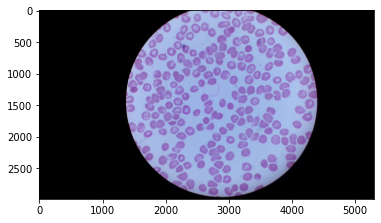

In [77]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
#img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#img = cv2.flip(img, 1)
plt.imshow(img)

In [78]:
# cv2.circle(img, df_file['position'][240][0], 1, (0,255,0), 50)
# plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


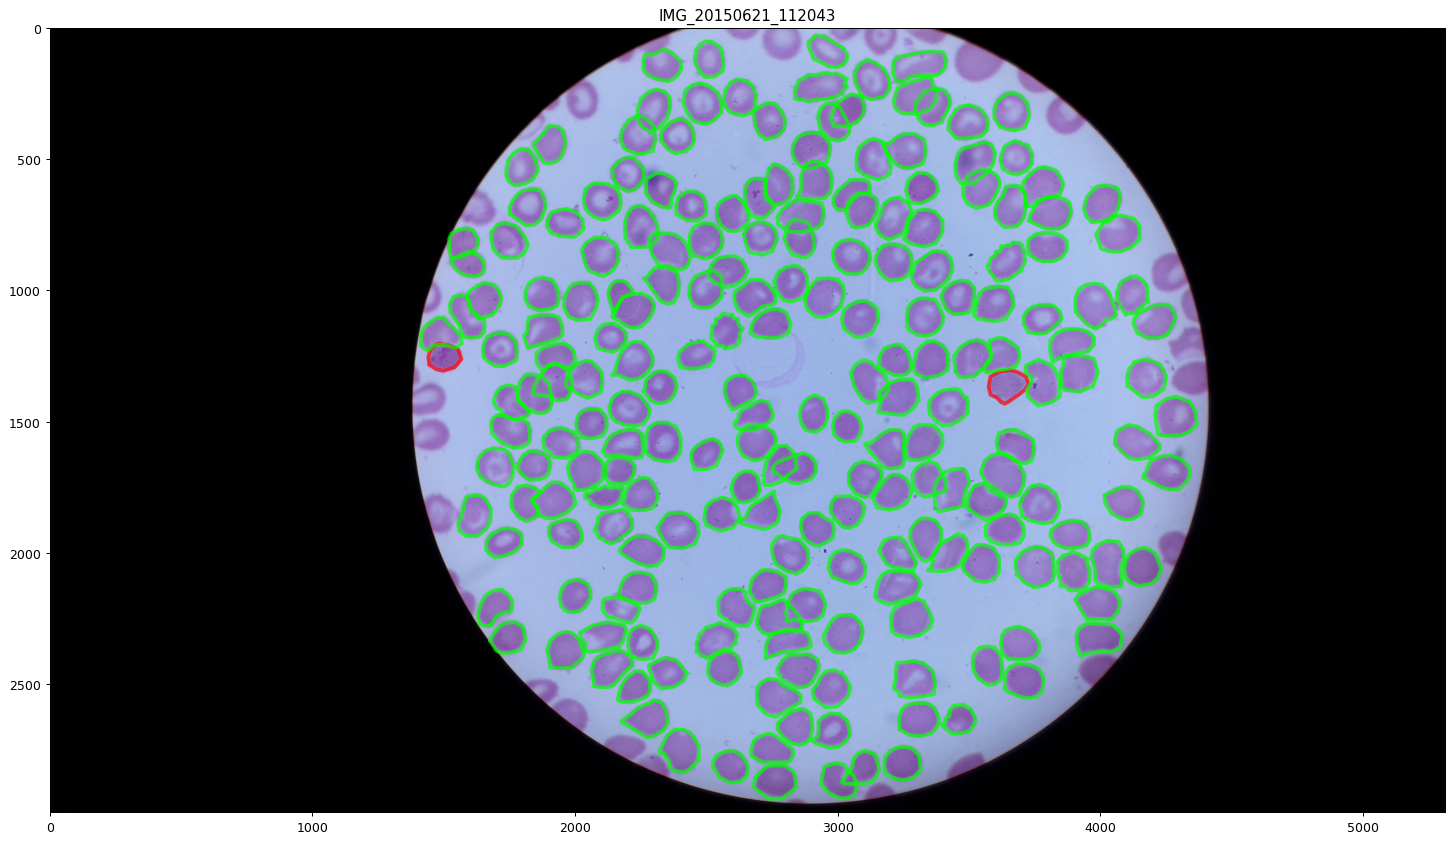

In [79]:
fig = plt.figure(1, figsize=(20,20), dpi=90)
df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row), axis = 1)
plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


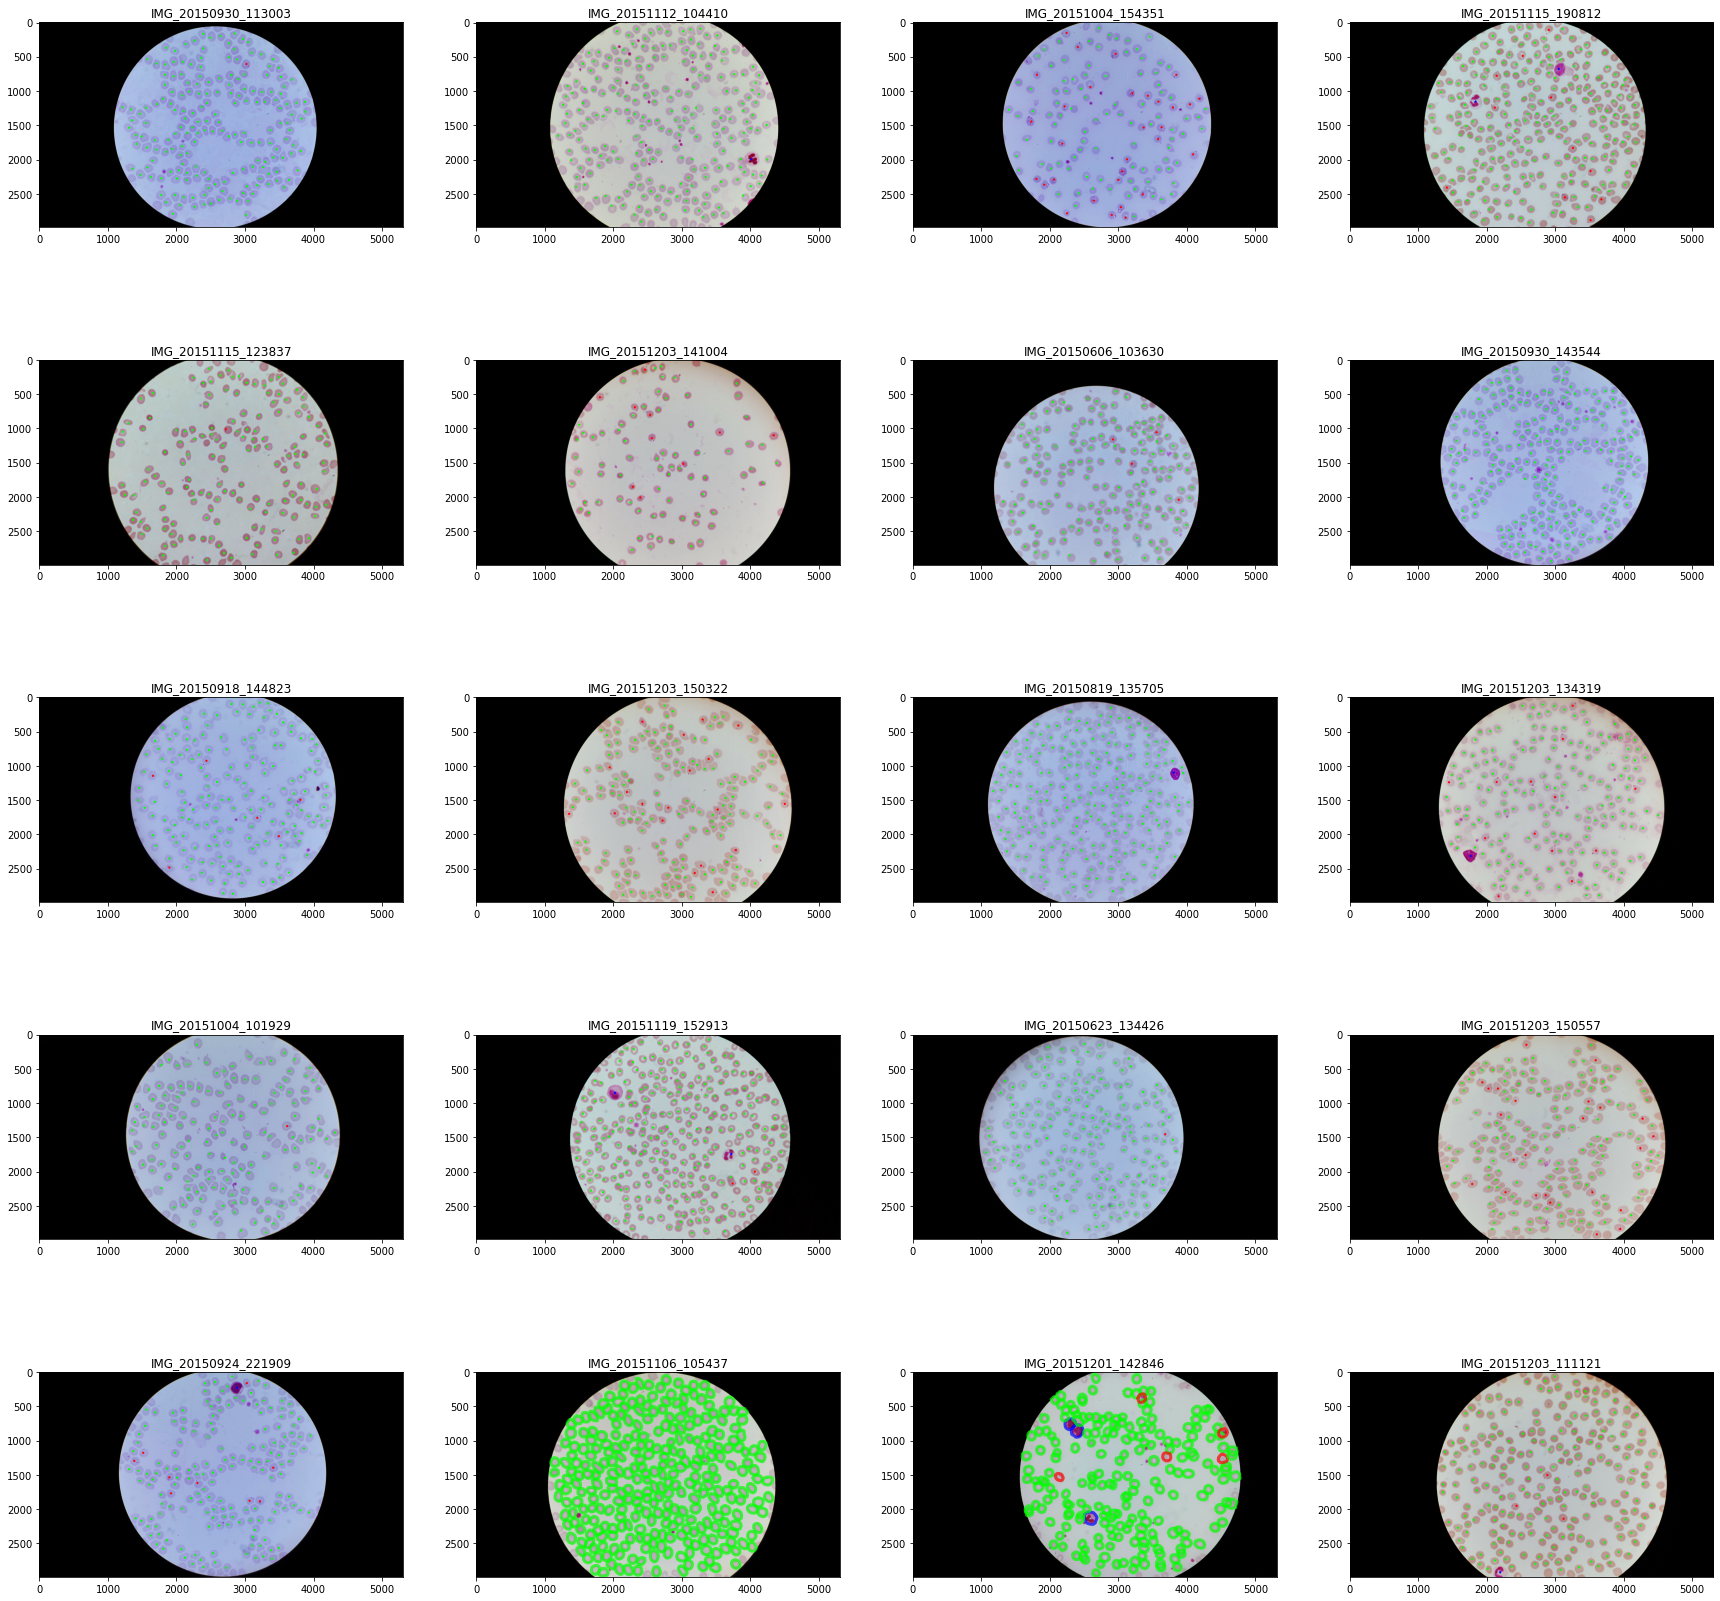

In [80]:
secure_random = random.SystemRandom()

w, h = 10, 10
fig=plt.figure(figsize=(30, 30))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    filename = secure_random.choice(df['filename'].unique())
    df_file = df[df['filename'] == filename]
    #print(filename)
    img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
    df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row = row, rows = rows, columns = columns, i = i, point_size= 30), axis = 1)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Polygons to mask

In [81]:
def poly_mask(row):
    poly = Polygon(row['position'])
    mask = poly.ravel().tolist()

In [82]:
filename =  'IMG_20151029_162934'

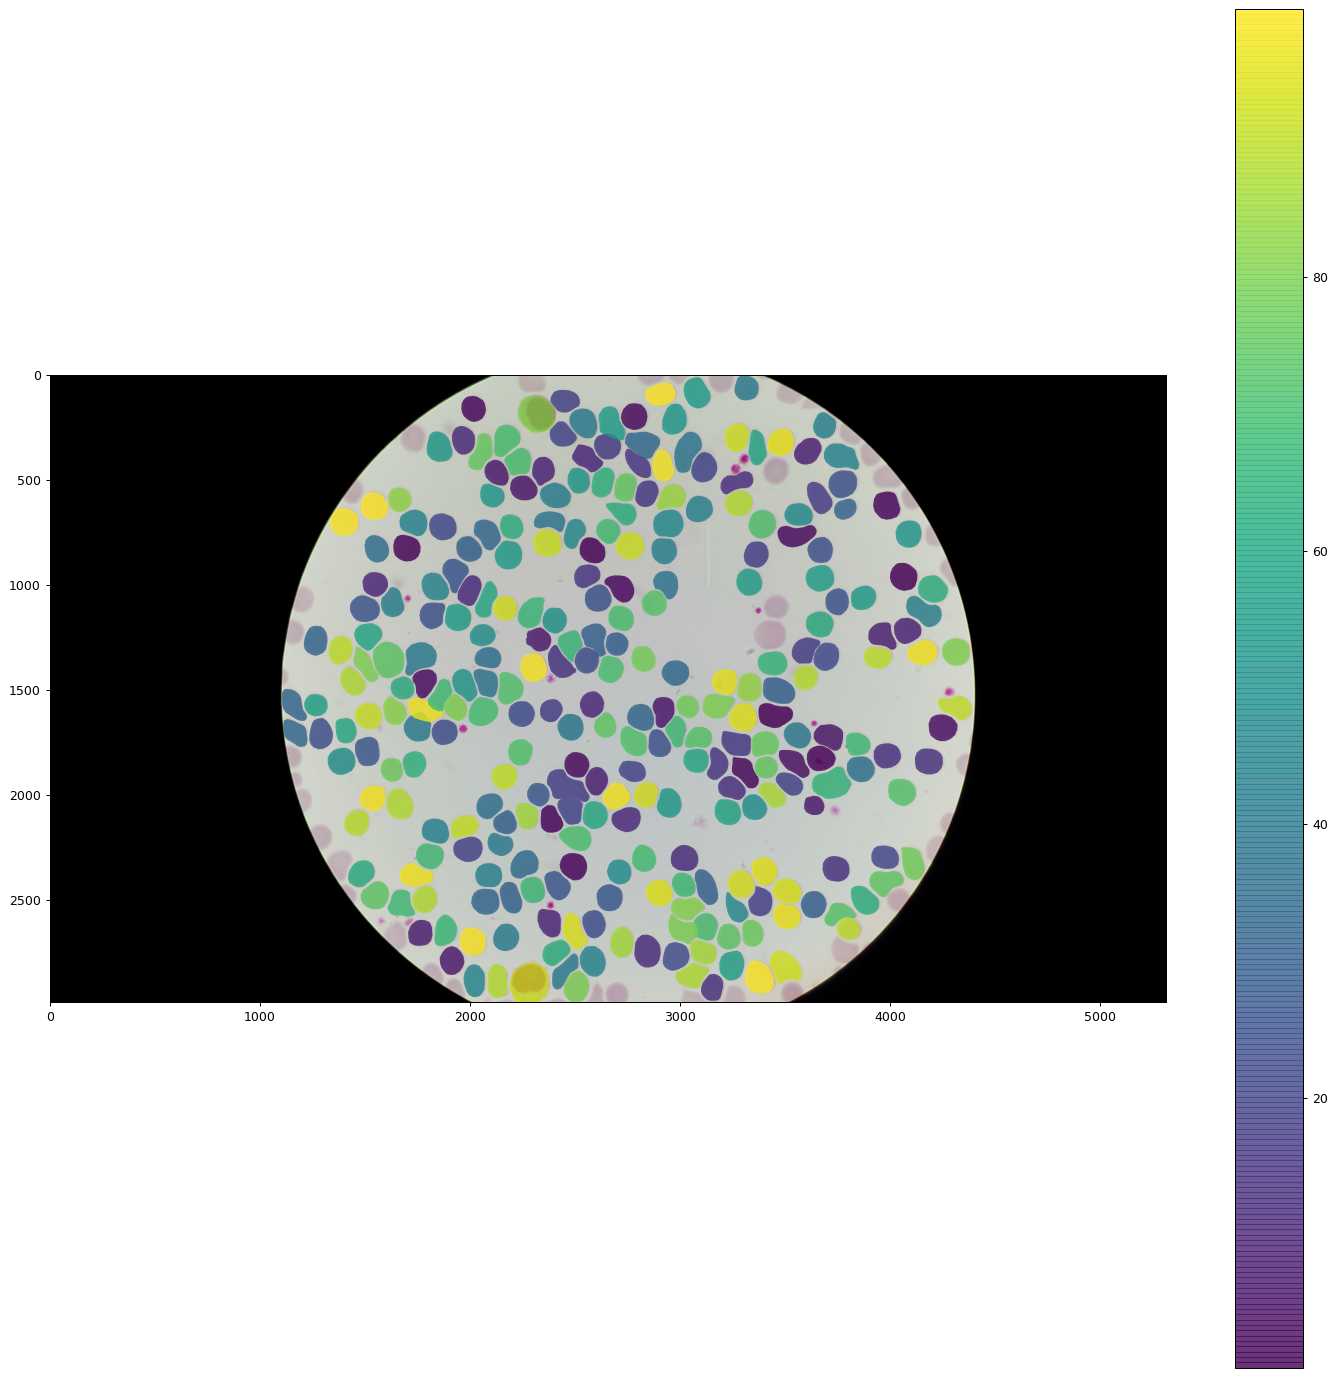

In [83]:
patches = []
patches = [ Polygon(poly) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position'] ]

img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
empty_img = Image.new("L", [img.shape[1], img.shape[0]], 0)
mask = np.array(empty_img)

fig = plt.figure(1, figsize=(20,20), dpi=90)
ax = fig.add_subplot(111)

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.8)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
plt.imshow(img)

image shape:  <PIL.Image.Image image mode=1 size=5312x2988 at 0x7EFBA1A71C88>


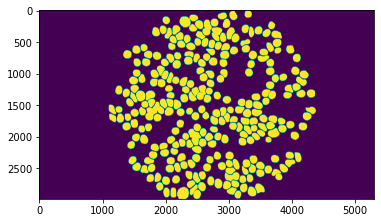

In [84]:
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)

img = Image.new("L", [img.shape[1], img.shape[0]], 0)
img = img.convert('1')
print('image shape: ', img)
[ ImageDraw.Draw(img).polygon(poly, outline=1, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)

plt.imshow(mask)

img.save('Images/polygon_mask.png')

In [85]:
def poly2mask(filename):
    img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
    img = Image.new("L", [img.shape[1], img.shape[0]], 0)
    img = img.convert('1')
    [ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
    # mask = np.array(img)
    # data = Image.fromarray(mask) 
    # # saving the final output  
    # # as a PNG file 
    # data = data.convert('1')
    # data.save(f'../masks/mask_{filename}.png')
    if not os.path.isdir('../data/masks'):
        os.makedirs('../data/masks')

    mask_path = f'../data/masks/mask_{filename}.png'
    img.save(mask_path)
    return mask, mask_path

In [86]:
filename =  'IMG_20150621_112043' #'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file

Patient no - Cell no         cell     comment annotation_type  \
15193                  2-1  Parasitized  No_comment         Polygon   
15194                  2-2  Parasitized  No_comment         Polygon   
15195                  2-3   Uninfected  No_comment         Polygon   
15196                  2-4   Uninfected  No_comment         Polygon   
15197                  2-5   Uninfected  No_comment         Polygon   
...                    ...          ...         ...             ...   
15397                2-205   Uninfected  No_comment         Polygon   
15398                2-206   Uninfected  No_comment         Polygon   
15399                2-207   Uninfected  No_comment         Polygon   
15400                2-208   Uninfected  No_comment         Polygon   
15401                2-209   Uninfected  No_comment         Polygon   

      Number of points                                           position  \
15193               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
15194               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
15195               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
15196               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
15197               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                ...                                                ...   
15397               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
15398               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
15399               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
15400               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
15401               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                  filename                                           txt_path  \
15193  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15194  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15195  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15196  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15197  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                    ...                                                ...   
15397  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15398  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15399  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15400  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15401  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                                img_path  
15193  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15194  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15195  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15196  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15197  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
...                                                  ...  
15397  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15398  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15399  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15400  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15401  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  

[209 rows x 9 columns]

## Connected Components

In [87]:
def connected_component_label(img):
    # https://iq.opengenus.org/connected-component-labeling/
    # https://stackoverflow.com/questions/13572448/replace-values-of-a-numpy-index-array-with-values-of-a-list


    num_labels, labels = cv2.connectedComponents(img)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    palette = np.arange(1, 179)
    list_rand_nums = np.random.randint(1,179, 179)
    # list_rand_nums gives the new values you wish palette to be mapped to.
    index = np.digitize(label_hue.ravel(), palette, right=True)
    random_hue = np.uint8(list_rand_nums[index].reshape(label_hue.shape))

    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([random_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    
    # Showing Original Image
    plt.imshow(mask)
    plt.axis("off")
    plt.title("Orginal Image")
    plt.show()
    
    #Showing Image after Component Labeling
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGRA2RGB))
    plt.axis('off')
    plt.title("Image after Component Labeling")
    plt.show()

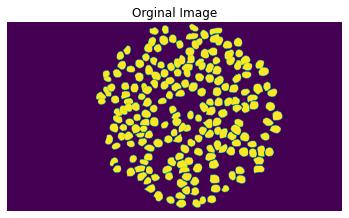

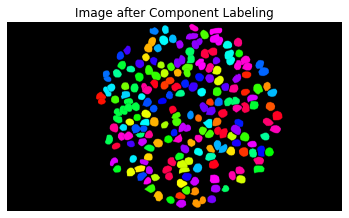

In [88]:
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
img = Image.new("L", [img.shape[1], img.shape[0]], 0)
#img = img.convert('1')
[ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)
connected_component_label(mask)

In [89]:
num_labels, labels = cv2.connectedComponents(mask)
print(len(labels[0]))
print(np.max(labels))

5312
175


In [90]:
df

Patient no - Cell no        cell     comment annotation_type  \
0                       3-1  Uninfected  No_comment         Polygon   
1                       3-2  Uninfected  No_comment         Polygon   
2                       3-3  Uninfected  No_comment         Polygon   
3                       3-4  Uninfected  No_comment         Polygon   
4                       3-5  Uninfected  No_comment         Polygon   
...                     ...         ...         ...             ...   
196929                5-200  Uninfected  No_Comment           Point   
196930                5-201  Uninfected  No_Comment           Point   
196931                5-202  Uninfected  No_Comment           Point   
196932                5-203  Uninfected  No_Comment           Point   
196933                5-204  Uninfected  No_Comment           Point   

       Number of points                                           position  \
0                    14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1                    15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2                    14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3                    14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4                    14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   
...                 ...                                                ...   
196929                1                                      [(2080, 643)]   
196930                1                                      [(1790, 606)]   
196931                1                                      [(1757, 756)]   
196932                1                                      [(1860, 856)]   
196933                1                                      [(1623, 683)]   

                   filename  \
0       IMG_20150817_103139   
1       IMG_20150817_103139   
2       IMG_20150817_103139   
3       IMG_20150817_103139   
4       IMG_20150817_103139   
...                     ...   
196929  IMG_20151115_181859   
196930  IMG_20151115_181859   
196931  IMG_20151115_181859   
196932  IMG_20151115_181859   
196933  IMG_20151115_181859   

                                                 txt_path  \
0       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                                                   ...   
196929  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196930  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196931  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196932  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196933  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                                                 img_path  
0       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
1       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
2       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
3       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
4       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
...                                                   ...  
196929  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  
196930  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  
196931  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  
196932  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  
196933  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  

[196934 rows x 9 columns]

In [91]:
def get_bbx(position, annotation_type, bb_pixel):
    if annotation_type == 'Polygon':
        poly_list = np.array([list(ele) for ele in position])
        x_min = np.nanmin(poly_list[:, 0])
        x_max = np.nanmax(poly_list[:, 0])
        y_min = np.nanmin(poly_list[:, 1])
        y_max = np.nanmax(poly_list[:, 1])
        return [x_min, y_min, x_max, y_max]
    if annotation_type == 'Point':
        point_list = np.array(position)
        x_min = int(point_list[:, 0] - 0.5 * bb_pixel)
        x_max = int(point_list[:, 0] + 0.5 * bb_pixel)
        y_min = int(point_list[:, 1] - 0.5 * bb_pixel)
        y_max = int(point_list[:, 1] + 0.5 * bb_pixel)
        return [x_min, y_min, x_max, y_max]

In [92]:
df['bbx'] = df.apply(lambda row: get_bbx(row['position'], row['annotation_type'], 140), axis = 1)
df

Patient no - Cell no        cell     comment annotation_type  \
0                       3-1  Uninfected  No_comment         Polygon   
1                       3-2  Uninfected  No_comment         Polygon   
2                       3-3  Uninfected  No_comment         Polygon   
3                       3-4  Uninfected  No_comment         Polygon   
4                       3-5  Uninfected  No_comment         Polygon   
...                     ...         ...         ...             ...   
196929                5-200  Uninfected  No_Comment           Point   
196930                5-201  Uninfected  No_Comment           Point   
196931                5-202  Uninfected  No_Comment           Point   
196932                5-203  Uninfected  No_Comment           Point   
196933                5-204  Uninfected  No_Comment           Point   

       Number of points                                           position  \
0                    14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1                    15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2                    14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3                    14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4                    14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   
...                 ...                                                ...   
196929                1                                      [(2080, 643)]   
196930                1                                      [(1790, 606)]   
196931                1                                      [(1757, 756)]   
196932                1                                      [(1860, 856)]   
196933                1                                      [(1623, 683)]   

                   filename  \
0       IMG_20150817_103139   
1       IMG_20150817_103139   
2       IMG_20150817_103139   
3       IMG_20150817_103139   
4       IMG_20150817_103139   
...                     ...   
196929  IMG_20151115_181859   
196930  IMG_20151115_181859   
196931  IMG_20151115_181859   
196932  IMG_20151115_181859   
196933  IMG_20151115_181859   

                                                 txt_path  \
0       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                                                   ...   
196929  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196930  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196931  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196932  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196933  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                                                 img_path  \
0       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                                                   ...   
196929  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196930  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196931  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196932  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196933  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                           bbx  
0        [2905, 33, 3033, 131]  
1       [2951, 141, 3071, 272]  
2       [2658, 135, 2801, 276]  
3       [2332, 137, 2454, 265]  
4       [2499, 140, 2631, 272]  
...                        ...  
196929  [2010, 573, 2150, 713]  
196930  [1720, 536, 1860, 676]  
196931  [1687, 686, 1827, 826]  
196932  [1790, 786, 1930, 926]  
196933  [1553, 

## Tiling images and labels

(2988, 5312)


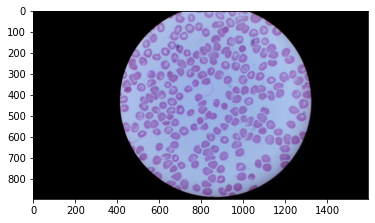

In [93]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
resize_factor = .3
print(img.shape[:2])
resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))), interpolation=cv2.INTER_AREA)
plt.imshow(resized_img)

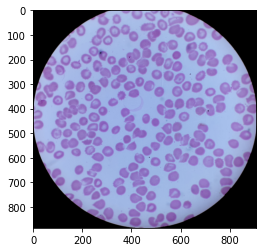

In [94]:
# select circle only
img_gray = rgb2gray(resized_img)
th = threshold_otsu(img_gray)
fg = img_gray>th
# Find the bounding box of those pixels
coords = np.array(np.nonzero(fg))
top_left = np.min(coords, axis=1)
bottom_right = np.max(coords, axis=1)

#set all under threshhold values to zero 
img_circle = resized_img*gray2rgb(fg)

img_cropped = img_circle[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]

plt.imshow(img_cropped)

In [95]:
df_file

Patient no - Cell no         cell     comment annotation_type  \
15193                  2-1  Parasitized  No_comment         Polygon   
15194                  2-2  Parasitized  No_comment         Polygon   
15195                  2-3   Uninfected  No_comment         Polygon   
15196                  2-4   Uninfected  No_comment         Polygon   
15197                  2-5   Uninfected  No_comment         Polygon   
...                    ...          ...         ...             ...   
15397                2-205   Uninfected  No_comment         Polygon   
15398                2-206   Uninfected  No_comment         Polygon   
15399                2-207   Uninfected  No_comment         Polygon   
15400                2-208   Uninfected  No_comment         Polygon   
15401                2-209   Uninfected  No_comment         Polygon   

      Number of points                                           position  \
15193               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
15194               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
15195               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
15196               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
15197               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                ...                                                ...   
15397               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
15398               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
15399               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
15400               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
15401               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                  filename                                           txt_path  \
15193  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15194  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15195  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15196  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15197  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                    ...                                                ...   
15397  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15398  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15399  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15400  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
15401  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                                img_path  
15193  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15194  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15195  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15196  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15197  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
...                                                  ...  
15397  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15398  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15399  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15400  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  
15401  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  

[209 rows x 9 columns]

In [96]:
def plot_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)

    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        #print(i)
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            #print(j)
            #print((offset[1]*i, min(offset[1]*i+tile_size[1], img_shape[0])), (offset[0]*j, min(offset[0]*j+tile_size[0], img_shape[1])))
            x_min = min(offset[1] * x + tile_size[1], img_shape[0])
            x_max = offset[1] * x
            y_min = min(offset[0] * y + tile_size[0], img_shape[1])
            y_max = offset[0]*y
            cv2.rectangle(img, (x_max, x_min), (y_max, y_min), (0, 0, 255), 3)
            #cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
            # Debugging the tiles
            #cv2.imwrite("debug_" + str(i) + "_" + str(j) + ".png", cropped_img)
    plt.imshow(crop_img)

def crop_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)
    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            x_min = offset[1] * x
            x_max = min(offset[1] * x + tile_size[1], img_shape[0])
            y_min = offset[0]*y
            y_max = min(offset[0] * y + tile_size[0], img_shape[1])
            crop_image = img[x_min : x_min + tile_w, y_min: y_min + tile_h]
            cv2.imwrite(f'../cropped/{x_min}_{x_max}_{y_min}_{y_max}.png', crop_image) 
    #plt.imshow(crop_image)


In [97]:
crop_tiles(img_cropped, 256, 256)

In [98]:
def convert_labels(path, x1, y1, x2, y2):
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin
    size = get_img_shape(path)
    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[1]
    dh = 1./size[0]
    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [99]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        order: [x1, y1, x2, y2] 
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : list
        order: [x1, y1, x2, y2]
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [100]:
def get_intersection_percent(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        order: [x1, y1, x2, y2] 
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : list
        order: [x1, y1, x2, y2]
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [101]:
get_intersection_percent( [0, 0, 10, 10], [0, 0, 20, 20])

1.0

In [102]:
###############################################################################
def slice_img(input_im, input_mask, 
                     filename,
                    outdir_im, 
                     outdir_mask,
                     outdir_label,
                      classes_dic, 
                     category, 
                     box_coords, resize_factor = 1,
                  sliceHeight=256, sliceWidth=256,
                  zero_frac_thresh=0, overlap=0, pad=0, verbose = False,
                  box_coords_dir='', yolt_coords_dir='', create_mask = False):
    '''
    ADAPTED FROM YOLT/SCRIPTS/SLICE_IM.PY
    Assume input_im is rgb
    Slice large image into smaller pieces,
    ignore slices with a percentage null greater then zero_fract_thresh'''
    if verbose == True:
        print('############# slice_img #############')
    img = cv2.imread(input_im, 1)  # color
    if create_mask:
        mask = cv2.imread(input_mask, 0)
    category_num = [classes_dic[k] for k in category] 

    resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))))
    if create_mask == True:
        resized_mask = cv2.resize(mask, (int(round(mask.shape[1] * resize_factor)), int(round(mask.shape[0] * resize_factor))))
    resized_box_coords = np.array(np.round(np.array(box_coords) * np.array(resize_factor)).astype(int))


    im_h, im_w = resized_img.shape[:2]
    if verbose:
        print('im_h', im_h)
        print('im_w', im_w)

    win_size = sliceHeight*sliceWidth

    # if slice sizes are large than image, pad the edges
    if sliceHeight > im_h:
        pad = sliceHeight - im_h
    if sliceWidth > im_w:
        pad = max(pad, sliceWidth - im_w)
    # pad the edge of the image with black pixels
    if pad > 0:
        border_color = (0, 0, 0)
        resized_img = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                                   cv2.BORDER_CONSTANT, value=border_color)
        if create_mask == True:
            resized_mask = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                                cv2.BORDER_CONSTANT, value=border_color)

    t0 = time.time()
    n_ims = 0
    n_ims_nonull = 0
    dx = int((1. - overlap) * sliceWidth)
    dy = int((1. - overlap) * sliceHeight)
    if verbose:
        print('dx', dx)
        print('dy', dy)
    dict_yolo = {}
    dict_bbx = {}
    max_annot = 0

    for y in range(0, im_h, dy):  # sliceHeight):
        for x in range(0, im_w, dx):  # sliceWidth):
            n_ims += 1
            # extract image
            # make sure we don't go past the edge of the image
            if y + sliceHeight > im_h:
                y0 = im_h - sliceHeight
            else:
                y0 = y
            if x + sliceWidth > im_w:
                x0 = im_w - sliceWidth
            else:
                x0 = x

            window_c = resized_img[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            if create_mask == True:
                window_mask = resized_mask[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
##           gt_c = gt_image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
#             gt_c = image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            win_h, win_w = window_c.shape[:2]
    
            outname_part = 'slice_' + filename + \
            '_' + str(y0) + '_' + str(x0) + \
            '_' + str(win_h) + '_' + str(win_w) + \
            '_' + str(pad)

            if create_mask == True:
                outname_mask_part = 'slice_mask_' + filename + \
                    '_' + str(y0) + '_' + str(x0) + \
                    '_' + str(win_h) + '_' + str(win_w) + \
                    '_' + str(pad)
        
            # [x0, x1, y0, y1]


            # get black and white image
            window = cv2.cvtColor(window_c, cv2.COLOR_BGR2GRAY)

            # find threshold of image that's not black
            # https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html?highlight=threshold
            ret, thresh1 = cv2.threshold(window, 2, 255, cv2.THRESH_BINARY)
            non_zero_counts = cv2.countNonZero(thresh1)
            zero_counts = win_size - non_zero_counts
            zero_frac = float(zero_counts) / win_size
            # print ("zero_frac", zero_fra
            # skip if image is mostly empty
            if zero_frac >= zero_frac_thresh:
                if verbose:
                    print("Zero frac too high at:", zero_frac)
                continue
                
            new_box_coords = []
            yolt_coords = []
            annot_count = 0

            for box, cat in zip(resized_box_coords, category_num):
                cut_box = 0
                percent_in_cut_img = get_intersection_percent(box, [x0, y0, x0 + sliceWidth, y0 + sliceHeight])

                if percent_in_cut_img > 0.75:   
                    resized_box_cat = np.asarray([box[0] - x0, box[1] - y0, box[2] - x0, box[3] - y0, cat])
                    new_box_coords.append(resized_box_cat)
                    annot_count += 1
                    # Input to convert: image size: (w,h), box: [x0, x1, y0, y1]
                    #print(box)
                    yolt_co_i = convert((win_w, win_h), box)
                    yolt_coords.append(yolt_co_i)

                    
            if annot_count > max_annot:
                max_annot = annot_count

            #  save
            outname_im = os.path.join(outdir_im, outname_part + '.png')
            if create_mask == True:
                outname_mask = os.path.join(outdir_mask, outname_mask_part + '.png')
            txt_outpath = os.path.join(outdir_label, outname_part + '.txt')

            dict_yolo[outname_im] = yolt_coords
            dict_bbx[outname_im] = new_box_coords
          

            # save yolt ims
            if verbose:
                print("image output:", outname_im)
            cv2.imwrite(outname_im, window_c)
            if create_mask == True:
                cv2.imwrite(outname_mask, window_mask)

            # save yolt labels
            txt_outfile = open(txt_outpath, "w+")
            if verbose:
                print("txt output:" + txt_outpath)
            for bb in yolt_coords:
                outstring = str(category_num) + " " + \
                    " ".join([str(a) for a in bb]) + '\n'
                if verbose:
                    print("outstring:", outstring)
                txt_outfile.write(outstring)
            txt_outfile.close()

            # if desired, save coords files
            # save box coords dictionary so that yolt_eval.py can read it
            if len(box_coords_dir) > 0:
                coords_dic = gt_dic_from_box_coords(box_coords)
                outname_pkl = os.path.join(
                    box_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(coords_dic, open(outname_pkl, 'wb'), protocol=2)
            if len(yolt_coords_dir) > 0:
                outname_pkl = os.path.join(
                    yolt_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(yolt_coords, open(outname_pkl, 'wb'), protocol=2)

            n_ims_nonull += 1

    if verbose:
        print("Num slices:", n_ims, "Num non-null slices:", n_ims_nonull,
              "sliceHeight", sliceHeight, "sliceWidth", sliceWidth)
        print("Time to slice", input_im, time.time()-t0, "seconds")

    return dict_yolo, dict_bbx, max_annot

def convert(size, box):
    '''Input = image size: (w,h), box: [x0, x1, y0, y1]'''
    dw = 1./size[0]
    dh = 1./size[1]
    xmid = (box[0] + box[1])/2.0
    ymid = (box[2] + box[3])/2.0
    w0 = box[1] - box[0]
    h0 = box[3] - box[2]
    x = xmid*dw
    y = ymid*dh
    w = w0*dw
    h = h0*dh
    return (x, y, w, h)

In [103]:
def cut_images(df,
                slice_height = 256,
                slice_width = 256,
                resize_factor = 0.3,
                classes_dic = {'Uninfected': 0, 'Parasitized': 1, 'White_Blood_Cell': 2},
                zero_frac_thresh = 0.9, 
                overlap = 0, 
                pad = 0,
                verbose=False):
    
    
    dict_mask = {}
    dict_bbxs = {}
    total_max_annot = 0
    mask_path = ''
    outdir_mask = ''

    for filename in df['filename'].unique():
        create_mask = False
        if df.loc[(df['filename'] == filename),'annotation_type'].iloc[-1] ==  'Polygon':
            # first we create a black and white mask where the polygons are white
            mask, mask_path = poly2mask(filename)
            dict_mask[filename] = mask_path
            # now lets slice the images (and bbx although we will proabaly not use them)
            filename = df.loc[(df['filename'] == filename),'filename'].iloc[-1]
            img_path = df.loc[(df['filename'] == filename),'img_path'].iloc[-1]

            if not os.path.isdir('../data/cropped'):
                os.makedirs('../data/cropped')

            outdir_im = f'../data/cropped/{filename}/img'
            outdir_mask = f'../data/cropped/{filename}/mask'
            outdir_label = f'../data/cropped/{filename}/labels'
            check_if_outdir_im = os.path.isdir(outdir_im)
            check_if_outdir_mask = os.path.isdir(outdir_mask)
            check_if_outdir_label = os.path.isdir(outdir_label)

            if not check_if_outdir_im:
                os.makedirs(outdir_im)
            if not check_if_outdir_mask:
                os.makedirs(outdir_mask)
            if not check_if_outdir_label:
                os.makedirs(outdir_label)
            create_mask = True

        else: 
            # now lets slice the images (and bbx although we will proabaly not use them)
            filename = df.loc[(df['filename'] == filename),'filename'].iloc[-1]
            img_path = df.loc[(df['filename'] == filename),'img_path'].iloc[-1]

            if not os.path.isdir('../data/cropped'):
                os.makedirs('../data/cropped')

            outdir_im = f'../data/cropped/{filename}/img'
            outdir_label = f'../data/cropped/{filename}/labels'
            check_if_outdir_im = os.path.isdir(outdir_im)
            check_if_outdir_label = os.path.isdir(outdir_label)

            if not check_if_outdir_im:
                os.makedirs(outdir_im)
            if not check_if_outdir_label:
                os.makedirs(outdir_label)


        box_coords = df.loc[(df['filename'] == filename),'bbx'].tolist()
        category = df.loc[(df['filename'] == filename),'cell'].tolist()

        dict_yolo, dict_bbx, \
            max_annot = slice_img(img_path, mask_path, 
                                filename,
                                outdir_im, 
                                outdir_mask, 
                                outdir_label,
                                classes_dic, 
                                category, 
                                box_coords, 
                            sliceHeight= slice_height, sliceWidth=slice_width,
                            resize_factor = resize_factor,
                            zero_frac_thresh = zero_frac_thresh, overlap = overlap, pad = pad, verbose=False,
                            box_coords_dir='', yolt_coords_dir='', create_mask = create_mask)

        if max_annot > total_max_annot:
            total_max_annot = max_annot
            
        dict_bbxs.update(dict_bbx)
            
        print('filename: ', filename, ', len dict_bbx: ', len(dict_bbxs))

    return dict_yolo, dict_bbxs, dict_mask, total_max_annot

In [104]:
#df_para = df.loc[(df['cell'] == 'Parasitized')].reset_index(drop=True)
df_para = df

In [105]:
df.loc[(df['cell'] == 'Parasitized') & (df['filename'] == 'IMG_20151116_110921')]

Patient no - Cell no         cell     comment annotation_type  \
143669                  2-1  Parasitized  No_Comment           Point   
143780                2-112  Parasitized  No_Comment           Point   

       Number of points        position             filename  \
143669                1  [(3338, 2542)]  IMG_20151116_110921   
143780                1  [(2416, 2038)]  IMG_20151116_110921   

                                                 txt_path  \
143669  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
143780  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                                                 img_path  \
143669  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
143780  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                             bbx  
143669  [3268, 2472, 3408, 2612]  
143780  [2346, 1968, 2486, 2108]

In [106]:
#dict_yolo, dict_bbxs, dict_mask, total_max_annot = cut_images(df_para, classes_dic = {'Parasitized': 1})
dict_yolo, dict_bbxs, dict_mask, total_max_annot = cut_images(df)

filename:  IMG_20150817_103139 , len dict_bbx:  15
filename:  IMG_20150817_103303 , len dict_bbx:  29
filename:  IMG_20150817_102702 , len dict_bbx:  43
filename:  IMG_20150817_102823 , len dict_bbx:  58
filename:  IMG_20150817_103901 , len dict_bbx:  73
filename:  IMG_20150725_123938 , len dict_bbx:  89
filename:  IMG_20150725_125213 , len dict_bbx:  105
filename:  IMG_20150725_125847 , len dict_bbx:  121
filename:  IMG_20150725_124606 , len dict_bbx:  137
filename:  IMG_20150725_124830 , len dict_bbx:  153
filename:  IMG_20151004_130810 , len dict_bbx:  167
filename:  IMG_20151004_130408 , len dict_bbx:  181
filename:  IMG_20151004_130549 , len dict_bbx:  195
filename:  IMG_20151004_131030 , len dict_bbx:  209
filename:  IMG_20151004_131129 , len dict_bbx:  223
filename:  IMG_20151029_162934 , len dict_bbx:  240
filename:  IMG_20151029_162357 , len dict_bbx:  257
filename:  IMG_20151029_162605 , len dict_bbx:  274
filename:  IMG_20151029_162439 , len dict_bbx:  291
filename:  IMG_201

filename:  IMG_20150813_163120 , len dict_bbx:  2491
filename:  IMG_20150813_161634 , len dict_bbx:  2506
filename:  IMG_20150813_162554 , len dict_bbx:  2521
filename:  IMG_20150813_162146 , len dict_bbx:  2536
filename:  IMG_20151119_143039 , len dict_bbx:  2553
filename:  IMG_20151118_163539 , len dict_bbx:  2569
filename:  IMG_20151119_143212 , len dict_bbx:  2585
filename:  IMG_20151118_172913 , len dict_bbx:  2601
filename:  IMG_20151118_173039 , len dict_bbx:  2619
filename:  IMG_20151115_151211 , len dict_bbx:  2635
filename:  IMG_20151115_150057 , len dict_bbx:  2652
filename:  IMG_20151115_151015 , len dict_bbx:  2668
filename:  IMG_20151115_150925 , len dict_bbx:  2684
filename:  IMG_20151115_150728 , len dict_bbx:  2700
filename:  IMG_20151112_144652 , len dict_bbx:  2717
filename:  IMG_20151112_144147 , len dict_bbx:  2733
filename:  IMG_20151112_144222 , len dict_bbx:  2750
filename:  IMG_20151112_144534 , len dict_bbx:  2767
filename:  IMG_20151112_144613 , len dict_bbx:

filename:  IMG_20151002_133540 , len dict_bbx:  5024
filename:  IMG_20151002_133427 , len dict_bbx:  5038
filename:  IMG_20151002_133158 , len dict_bbx:  5052
filename:  IMG_20151002_132926 , len dict_bbx:  5066
filename:  IMG_20151005_141946 , len dict_bbx:  5080
filename:  IMG_20151005_141803 , len dict_bbx:  5094
filename:  IMG_20151005_140538 , len dict_bbx:  5108
filename:  IMG_20151005_140646 , len dict_bbx:  5122
filename:  IMG_20151005_141321 , len dict_bbx:  5136
filename:  IMG_20150918_170850 , len dict_bbx:  5150
filename:  IMG_20150918_172214 , len dict_bbx:  5164
filename:  IMG_20150918_171751 , len dict_bbx:  5178
filename:  IMG_20150918_172053 , len dict_bbx:  5192
filename:  IMG_20150918_171154 , len dict_bbx:  5208
filename:  IMG_20150609_122034 , len dict_bbx:  5223
filename:  IMG_20150609_122227 , len dict_bbx:  5242
filename:  IMG_20150609_122108 , len dict_bbx:  5257
filename:  IMG_20150609_122006 , len dict_bbx:  5272
filename:  IMG_20150609_122020 , len dict_bbx:

filename:  IMG_20150821_124504 , len dict_bbx:  7476
filename:  IMG_20150821_123314 , len dict_bbx:  7491
filename:  IMG_20150821_124937 , len dict_bbx:  7506
filename:  IMG_20150821_124739 , len dict_bbx:  7521
filename:  IMG_20151005_183338 , len dict_bbx:  7535
filename:  IMG_20151005_182257 , len dict_bbx:  7551
filename:  IMG_20151005_182822 , len dict_bbx:  7565
filename:  IMG_20151005_182410 , len dict_bbx:  7579
filename:  IMG_20151005_182527 , len dict_bbx:  7593
filename:  IMG_20150609_122547 , len dict_bbx:  7608
filename:  IMG_20150609_122327 , len dict_bbx:  7627
filename:  IMG_20150609_121955 , len dict_bbx:  7646
filename:  IMG_20150609_122421 , len dict_bbx:  7661
filename:  IMG_20150609_122725 , len dict_bbx:  7678
filename:  IMG_20151119_120111 , len dict_bbx:  7695
filename:  IMG_20151119_120019 , len dict_bbx:  7712
filename:  IMG_20151119_120150 , len dict_bbx:  7729
filename:  IMG_20151119_115918 , len dict_bbx:  7746
filename:  IMG_20151119_120233 , len dict_bbx:

filename:  IMG_20151116_102655 , len dict_bbx:  9977
filename:  IMG_20151116_104451 , len dict_bbx:  9993
filename:  IMG_20151116_104342 , len dict_bbx:  10009
filename:  IMG_20151116_102751 , len dict_bbx:  10025
filename:  IMG_20150821_115846 , len dict_bbx:  10040
filename:  IMG_20150821_115310 , len dict_bbx:  10055
filename:  IMG_20150821_120044 , len dict_bbx:  10070
filename:  IMG_20150821_115700 , len dict_bbx:  10085
filename:  IMG_20150821_115056 , len dict_bbx:  10100
filename:  IMG_20150818_164008 , len dict_bbx:  10116
filename:  IMG_20150818_163551 , len dict_bbx:  10132
filename:  IMG_20150818_164702 , len dict_bbx:  10148
filename:  IMG_20150818_163419 , len dict_bbx:  10164
filename:  IMG_20150818_164408 , len dict_bbx:  10180
filename:  IMG_20151203_150222 , len dict_bbx:  10199
filename:  IMG_20151203_150322 , len dict_bbx:  10218
filename:  IMG_20151203_150132 , len dict_bbx:  10237
filename:  IMG_20151203_150408 , len dict_bbx:  10256
filename:  IMG_20151203_150557

filename:  IMG_20150930_102716 , len dict_bbx:  12424
filename:  IMG_20150930_103214 , len dict_bbx:  12440
filename:  IMG_20150815_163225 , len dict_bbx:  12456
filename:  IMG_20150815_162935 , len dict_bbx:  12472
filename:  IMG_20150815_163147 , len dict_bbx:  12488
filename:  IMG_20150815_163015 , len dict_bbx:  12504
filename:  IMG_20150815_163059 , len dict_bbx:  12520
filename:  IMG_20151015_155149 , len dict_bbx:  12537
filename:  IMG_20151015_163142 , len dict_bbx:  12553
filename:  IMG_20151015_155004 , len dict_bbx:  12569
filename:  IMG_20151015_160529 , len dict_bbx:  12586
filename:  IMG_20151015_160908 , len dict_bbx:  12603
filename:  IMG_20150724_153313 , len dict_bbx:  12618
filename:  IMG_20150724_155046 , len dict_bbx:  12633
filename:  IMG_20150724_155557 , len dict_bbx:  12648
filename:  IMG_20150724_154330 , len dict_bbx:  12663
filename:  IMG_20150724_154243 , len dict_bbx:  12678
filename:  IMG_20151115_190642 , len dict_bbx:  12694
filename:  IMG_20151115_1855

filename:  IMG_20151115_153831 , len dict_bbx:  14765
filename:  IMG_20151115_154022 , len dict_bbx:  14781
filename:  IMG_20151115_155104 , len dict_bbx:  14797
filename:  IMG_20151115_154435 , len dict_bbx:  14813
filename:  IMG_20151115_154313 , len dict_bbx:  14829
filename:  IMG_20150614_131553 , len dict_bbx:  14844
filename:  IMG_20150614_131417 , len dict_bbx:  14859
filename:  IMG_20150614_131529 , len dict_bbx:  14875
filename:  IMG_20150614_131457 , len dict_bbx:  14890
filename:  IMG_20150614_131318 , len dict_bbx:  14905
filename:  IMG_20150918_145422 , len dict_bbx:  14919
filename:  IMG_20150918_144823 , len dict_bbx:  14933
filename:  IMG_20150918_144348 , len dict_bbx:  14947
filename:  IMG_20150918_145042 , len dict_bbx:  14961
filename:  IMG_20150918_144104 , len dict_bbx:  14975
filename:  IMG_20150817_124418 , len dict_bbx:  14990
filename:  IMG_20150817_123824 , len dict_bbx:  15005
filename:  IMG_20150817_123500 , len dict_bbx:  15019
filename:  IMG_20150817_1236

In [107]:
df['mask_path'] = df['filename'].map(dict_mask)

In [108]:
len(dict_bbxs.keys())

15381

In [109]:
# same as above however this time checking for image slice with most parasites

imgs_name = keys = np.array(list(dict_bbxs.keys()))
true_boxes = np.zeros((imgs_name.shape[0], total_max_annot, 5))
print('imgs_name.shape: ', imgs_name.shape)
print('max_annot: ', total_max_annot)
print('true_boxes shape: ', true_boxes.shape)

max_parasitized = {}
            
for key, boxes in dict_bbxs.items():
    count_para = 0
    boxes = np.asarray(boxes)
    idx = int(np.where(imgs_name == key)[0])
    print('boxes shape: ', boxes.shape)
    print('key: ', key)
    print('index in list: ', idx)

    if len(boxes) != 0:
        for box in boxes:
            if box[4] == 1:
                count_para += 1
    max_parasitized[idx] = count_para
    
    if len(boxes) == 0:
        boxes = np.asarray([[0,0,0,0,0]])
    true_boxes[idx, :boxes.shape[0], :5] = boxes

imgs_name.shape:  (15381,)
max_annot:  35
true_boxes shape:  (15381, 35, 5)
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_0_512_256_256_0.png
index in list:  0
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_0_768_256_256_0.png
index in list:  1
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_0_1024_256_256_0.png
index in list:  2
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_256_256_256_256_0.png
index in list:  3
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_256_512_256_256_0.png
index in list:  4
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_256_768_256_256_0.png
index in list:  5
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_256_1024_256_256_0.png
index in l

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_256_1024_256_256_0.png
index in list:  112
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_512_256_256_256_0.png
index in list:  113
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_512_512_256_256_0.png
index in list:  114
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_512_768_256_256_0.png
index in list:  115
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_512_1024_256_256_0.png
index in list:  116
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_640_256_256_256_0.png
index in list:  117
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_640_512_256_256_0.png
index in list:  118
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_

boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_512_512_256_256_0.png
index in list:  284
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_512_768_256_256_0.png
index in list:  285
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_512_1024_256_256_0.png
index in list:  286
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_640_256_256_256_0.png
index in list:  287
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_640_512_256_256_0.png
index in list:  288
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_640_768_256_256_0.png
index in list:  289
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_640_1024_256_256_0.png
index in list:  290
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_

boxes shape:  (0,)
key:  ../data/cropped/IMG_20150820_123717/img/slice_IMG_20150820_123717_640_256_256_256_0.png
index in list:  449
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150820_123717/img/slice_IMG_20150820_123717_640_512_256_256_0.png
index in list:  450
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150820_123717/img/slice_IMG_20150820_123717_640_768_256_256_0.png
index in list:  451
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150820_123717/img/slice_IMG_20150820_123717_640_1024_256_256_0.png
index in list:  452
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150820_124259/img/slice_IMG_20150820_124259_0_512_256_256_0.png
index in list:  453
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150820_124259/img/slice_IMG_20150820_124259_0_768_256_256_0.png
index in list:  454
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150820_124259/img/slice_IMG_20150820_124259_0_1024_256_256_0.png
index in list:  455
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150820_1

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_256_768_256_256_0.png
index in list:  631
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_256_1024_256_256_0.png
index in list:  632
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_512_256_256_256_0.png
index in list:  633
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_512_512_256_256_0.png
index in list:  634
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_512_768_256_256_0.png
index in list:  635
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_512_1024_256_256_0.png
index in list:  636
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_640_256_256_256_0.png
index in list:  637
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151116_093109/img/slice_IMG_20151116_093109_640_512_256_256_0.png
index in list:  806
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151116_093109/img/slice_IMG_20151116_093109_640_768_256_256_0.png
index in list:  807
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151116_093109/img/slice_IMG_20151116_093109_640_1024_256_256_0.png
index in list:  808
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_0_256_256_256_0.png
index in list:  809
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_0_512_256_256_0.png
index in list:  810
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_0_768_256_256_0.png
index in list:  811
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_0_1024_256_256_0.png
index in list:  812
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151116_092

boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151116_093629/img/slice_IMG_20151116_093629_512_768_256_256_0.png
index in list:  867
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151116_093629/img/slice_IMG_20151116_093629_512_1024_256_256_0.png
index in list:  868
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151116_093629/img/slice_IMG_20151116_093629_640_256_256_256_0.png
index in list:  869
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151116_093629/img/slice_IMG_20151116_093629_640_512_256_256_0.png
index in list:  870
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151116_093629/img/slice_IMG_20151116_093629_640_768_256_256_0.png
index in list:  871
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151116_093629/img/slice_IMG_20151116_093629_640_1024_256_256_0.png
index in list:  872
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150820_162813/img/slice_IMG_20150820_162813_0_512_256_256_0.png
index in list:  873
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151201_143025/img/slice_IMG_20151201_143025_640_1024_256_256_0.png
index in list:  984
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151201_143025/img/slice_IMG_20151201_143025_640_1280_256_256_0.png
index in list:  985
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151201_141604/img/slice_IMG_20151201_141604_0_512_256_256_0.png
index in list:  986
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151201_141604/img/slice_IMG_20151201_141604_0_768_256_256_0.png
index in list:  987
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151201_141604/img/slice_IMG_20151201_141604_0_1024_256_256_0.png
index in list:  988
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_141604/img/slice_IMG_20151201_141604_0_1280_256_256_0.png
index in list:  989
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_141604/img/slice_IMG_20151201_141604_256_256_256_256_0.png
index in list:  990
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151201_

boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151106_112853/img/slice_IMG_20151106_112853_0_512_256_256_0.png
index in list:  1150
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151106_112853/img/slice_IMG_20151106_112853_0_768_256_256_0.png
index in list:  1151
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151106_112853/img/slice_IMG_20151106_112853_0_1024_256_256_0.png
index in list:  1152
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151106_112853/img/slice_IMG_20151106_112853_256_256_256_256_0.png
index in list:  1153
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151106_112853/img/slice_IMG_20151106_112853_256_512_256_256_0.png
index in list:  1154
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151106_112853/img/slice_IMG_20151106_112853_256_768_256_256_0.png
index in list:  1155
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151106_112853/img/slice_IMG_20151106_112853_256_1024_256_256_0.png
index in list:  1156
boxes shape:  (12, 5)
key:  ../data/cropped/IM

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150724_102843/img/slice_IMG_20150724_102843_256_1024_256_256_0.png
index in list:  1309
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150724_102843/img/slice_IMG_20150724_102843_512_256_256_256_0.png
index in list:  1310
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150724_102843/img/slice_IMG_20150724_102843_512_512_256_256_0.png
index in list:  1311
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150724_102843/img/slice_IMG_20150724_102843_512_768_256_256_0.png
index in list:  1312
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150724_102843/img/slice_IMG_20150724_102843_512_1024_256_256_0.png
index in list:  1313
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150724_102843/img/slice_IMG_20150724_102843_640_256_256_256_0.png
index in list:  1314
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150724_102843/img/slice_IMG_20150724_102843_640_512_256_256_0.png
index in list:  1315
boxes shape:  (16, 5)
key:  ../data/cropp

boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_164834/img/slice_IMG_20151112_164834_512_1024_256_256_0.png
index in list:  1474
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151112_164834/img/slice_IMG_20151112_164834_640_256_256_256_0.png
index in list:  1475
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_164834/img/slice_IMG_20151112_164834_640_512_256_256_0.png
index in list:  1476
boxes shape:  (28, 5)
key:  ../data/cropped/IMG_20151112_164834/img/slice_IMG_20151112_164834_640_768_256_256_0.png
index in list:  1477
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151112_164834/img/slice_IMG_20151112_164834_640_1024_256_256_0.png
index in list:  1478
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151112_164625/img/slice_IMG_20151112_164625_0_256_256_256_0.png
index in list:  1479
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_164625/img/slice_IMG_20151112_164625_0_512_256_256_0.png
index in list:  1480
boxes shape:  (24, 5)
key:  ../data/cropped/I

boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_256_768_256_256_0.png
index in list:  1643
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_256_1024_256_256_0.png
index in list:  1644
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_256_1280_256_256_0.png
index in list:  1645
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_512_256_256_256_0.png
index in list:  1646
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_512_512_256_256_0.png
index in list:  1647
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_512_768_256_256_0.png
index in list:  1648
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_512_1024_256_256_0.png
index in list:  1649
boxes shape:  (2, 5)
key:  ../data/cropped

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150819_134112/img/slice_IMG_20150819_134112_640_1024_256_256_0.png
index in list:  1820
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150930_162315/img/slice_IMG_20150930_162315_0_256_256_256_0.png
index in list:  1821
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150930_162315/img/slice_IMG_20150930_162315_0_512_256_256_0.png
index in list:  1822
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150930_162315/img/slice_IMG_20150930_162315_0_768_256_256_0.png
index in list:  1823
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150930_162315/img/slice_IMG_20150930_162315_0_1024_256_256_0.png
index in list:  1824
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150930_162315/img/slice_IMG_20150930_162315_256_256_256_256_0.png
index in list:  1825
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150930_162315/img/slice_IMG_20150930_162315_256_512_256_256_0.png
index in list:  1826
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150930_162038/img/slice_IMG_20150930_162038_256_512_256_256_0.png
index in list:  1883
boxes shape:  (27, 5)
key:  ../data/cropped/IMG_20150930_162038/img/slice_IMG_20150930_162038_256_768_256_256_0.png
index in list:  1884
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150930_162038/img/slice_IMG_20150930_162038_256_1024_256_256_0.png
index in list:  1885
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150930_162038/img/slice_IMG_20150930_162038_512_256_256_256_0.png
index in list:  1886
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150930_162038/img/slice_IMG_20150930_162038_512_512_256_256_0.png
index in list:  1887
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150930_162038/img/slice_IMG_20150930_162038_512_768_256_256_0.png
index in list:  1888
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150930_162038/img/slice_IMG_20150930_162038_512_1024_256_256_0.png
index in list:  1889
boxes shape:  (17, 5)
key:  ../data/cropp

boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_640_1024_256_256_0.png
index in list:  2003
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150611_104404/img/slice_IMG_20150611_104404_0_512_256_256_0.png
index in list:  2004
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150611_104404/img/slice_IMG_20150611_104404_0_768_256_256_0.png
index in list:  2005
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150611_104404/img/slice_IMG_20150611_104404_0_1024_256_256_0.png
index in list:  2006
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150611_104404/img/slice_IMG_20150611_104404_256_256_256_256_0.png
index in list:  2007
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150611_104404/img/slice_IMG_20150611_104404_256_512_256_256_0.png
index in list:  2008
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150611_104404/img/slice_IMG_20150611_104404_256_768_256_256_0.png
index in list:  2009
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150714_093715/img/slice_IMG_20150714_093715_0_768_256_256_0.png
index in list:  2188
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150714_093715/img/slice_IMG_20150714_093715_0_1024_256_256_0.png
index in list:  2189
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150714_093715/img/slice_IMG_20150714_093715_256_256_256_256_0.png
index in list:  2190
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150714_093715/img/slice_IMG_20150714_093715_256_512_256_256_0.png
index in list:  2191
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150714_093715/img/slice_IMG_20150714_093715_256_768_256_256_0.png
index in list:  2192
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150714_093715/img/slice_IMG_20150714_093715_256_1024_256_256_0.png
index in list:  2193
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150714_093715/img/slice_IMG_20150714_093715_256_1280_256_256_0.png
index in list:  2194
boxes shape:  (4, 5)
key:  ../data/cropped/IM

boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_640_256_256_256_0.png
index in list:  2377
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_640_512_256_256_0.png
index in list:  2378
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_640_768_256_256_0.png
index in list:  2379
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_640_1024_256_256_0.png
index in list:  2380
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150729_104027/img/slice_IMG_20150729_104027_0_256_256_256_0.png
index in list:  2381
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150729_104027/img/slice_IMG_20150729_104027_0_512_256_256_0.png
index in list:  2382
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150729_104027/img/slice_IMG_20150729_104027_0_768_256_256_0.png
index in list:  2383
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151118_163539/img/slice_IMG_20151118_163539_512_1024_256_256_0.png
index in list:  2564
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151118_163539/img/slice_IMG_20151118_163539_512_1280_256_256_0.png
index in list:  2565
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151118_163539/img/slice_IMG_20151118_163539_640_512_256_256_0.png
index in list:  2566
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151118_163539/img/slice_IMG_20151118_163539_640_768_256_256_0.png
index in list:  2567
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151118_163539/img/slice_IMG_20151118_163539_640_1024_256_256_0.png
index in list:  2568
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151119_143212/img/slice_IMG_20151119_143212_0_512_256_256_0.png
index in list:  2569
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151119_143212/img/slice_IMG_20151119_143212_0_768_256_256_0.png
index in list:  2570
boxes shape:  (11, 5)
key:  ../data/cropped

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151112_144534/img/slice_IMG_20151112_144534_256_1024_256_256_0.png
index in list:  2757
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151112_144534/img/slice_IMG_20151112_144534_256_1280_256_256_0.png
index in list:  2758
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151112_144534/img/slice_IMG_20151112_144534_512_256_256_256_0.png
index in list:  2759
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_144534/img/slice_IMG_20151112_144534_512_512_256_256_0.png
index in list:  2760
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151112_144534/img/slice_IMG_20151112_144534_512_768_256_256_0.png
index in list:  2761
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_144534/img/slice_IMG_20151112_144534_512_1024_256_256_0.png
index in list:  2762
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151112_144534/img/slice_IMG_20151112_144534_640_256_256_256_0.png
index in list:  2763
boxes shape:  (18, 5)
key:  ../data/crop

boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151115_121725/img/slice_IMG_20151115_121725_256_768_256_256_0.png
index in list:  2943
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151115_121725/img/slice_IMG_20151115_121725_256_1024_256_256_0.png
index in list:  2944
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151115_121725/img/slice_IMG_20151115_121725_512_256_256_256_0.png
index in list:  2945
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151115_121725/img/slice_IMG_20151115_121725_512_512_256_256_0.png
index in list:  2946
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151115_121725/img/slice_IMG_20151115_121725_512_768_256_256_0.png
index in list:  2947
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151115_121725/img/slice_IMG_20151115_121725_512_1024_256_256_0.png
index in list:  2948
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151115_121725/img/slice_IMG_20151115_121725_640_256_256_256_0.png
index in list:  2949
boxes shape:  (19, 5)
key:  ../data/crop

boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150614_124301/img/slice_IMG_20150614_124301_640_256_256_256_0.png
index in list:  3128
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150614_124301/img/slice_IMG_20150614_124301_640_512_256_256_0.png
index in list:  3129
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150614_124301/img/slice_IMG_20150614_124301_640_768_256_256_0.png
index in list:  3130
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150614_124301/img/slice_IMG_20150614_124301_640_1024_256_256_0.png
index in list:  3131
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150614_124212/img/slice_IMG_20150614_124212_0_512_256_256_0.png
index in list:  3132
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150614_124212/img/slice_IMG_20150614_124212_0_768_256_256_0.png
index in list:  3133
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150614_124212/img/slice_IMG_20150614_124212_0_1024_256_256_0.png
index in list:  3134
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_

boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150606_104106/img/slice_IMG_20150606_104106_0_768_256_256_0.png
index in list:  3305
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150606_104106/img/slice_IMG_20150606_104106_256_256_256_256_0.png
index in list:  3306
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150606_104106/img/slice_IMG_20150606_104106_256_512_256_256_0.png
index in list:  3307
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150606_104106/img/slice_IMG_20150606_104106_256_768_256_256_0.png
index in list:  3308
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150606_104106/img/slice_IMG_20150606_104106_256_1024_256_256_0.png
index in list:  3309
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150606_104106/img/slice_IMG_20150606_104106_512_256_256_256_0.png
index in list:  3310
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150606_104106/img/slice_IMG_20150606_104106_512_512_256_256_0.png
index in list:  3311
boxes shape:  (21, 5)
key:  ../data/cropped/I

boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150821_171631/img/slice_IMG_20150821_171631_512_768_256_256_0.png
index in list:  3484
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150821_171631/img/slice_IMG_20150821_171631_512_1024_256_256_0.png
index in list:  3485
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150821_171631/img/slice_IMG_20150821_171631_640_256_256_256_0.png
index in list:  3486
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150821_171631/img/slice_IMG_20150821_171631_640_512_256_256_0.png
index in list:  3487
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150821_171631/img/slice_IMG_20150821_171631_640_768_256_256_0.png
index in list:  3488
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150821_171631/img/slice_IMG_20150821_171631_640_1024_256_256_0.png
index in list:  3489
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150821_171603/img/slice_IMG_20150821_171603_0_256_256_256_0.png
index in list:  3490
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151203_140902/img/slice_IMG_20151203_140902_512_1024_256_256_0.png
index in list:  3650
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151203_140902/img/slice_IMG_20151203_140902_512_1280_256_256_0.png
index in list:  3651
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151203_140902/img/slice_IMG_20151203_140902_640_256_256_256_0.png
index in list:  3652
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151203_140902/img/slice_IMG_20151203_140902_640_512_256_256_0.png
index in list:  3653
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151203_140902/img/slice_IMG_20151203_140902_640_768_256_256_0.png
index in list:  3654
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151203_140902/img/slice_IMG_20151203_140902_640_1024_256_256_0.png
index in list:  3655
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151203_141004/img/slice_IMG_20151203_141004_0_512_256_256_0.png
index in list:  3656
boxes shape:  (8, 5)
key:  ../data/cropped/IMG

boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151115_092605/img/slice_IMG_20151115_092605_256_768_256_256_0.png
index in list:  3820
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151115_092605/img/slice_IMG_20151115_092605_256_1024_256_256_0.png
index in list:  3821
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151115_092605/img/slice_IMG_20151115_092605_256_1280_256_256_0.png
index in list:  3822
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151115_092605/img/slice_IMG_20151115_092605_256_1338_256_256_0.png
index in list:  3823
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151115_092605/img/slice_IMG_20151115_092605_512_256_256_256_0.png
index in list:  3824
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151115_092605/img/slice_IMG_20151115_092605_512_512_256_256_0.png
index in list:  3825
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151115_092605/img/slice_IMG_20151115_092605_512_768_256_256_0.png
index in list:  3826
boxes shape:  (18, 5)
key:  ../data/cropp

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151112_113915/img/slice_IMG_20151112_113915_0_256_256_256_0.png
index in list:  3994
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_113915/img/slice_IMG_20151112_113915_0_512_256_256_0.png
index in list:  3995
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151112_113915/img/slice_IMG_20151112_113915_0_768_256_256_0.png
index in list:  3996
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151112_113915/img/slice_IMG_20151112_113915_0_1024_256_256_0.png
index in list:  3997
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151112_113915/img/slice_IMG_20151112_113915_256_256_256_256_0.png
index in list:  3998
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_113915/img/slice_IMG_20151112_113915_256_512_256_256_0.png
index in list:  3999
boxes shape:  (29, 5)
key:  ../data/cropped/IMG_20151112_113915/img/slice_IMG_20151112_113915_256_768_256_256_0.png
index in list:  4000
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20

boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_161024/img/slice_IMG_20151112_161024_0_768_256_256_0.png
index in list:  4164
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151112_161024/img/slice_IMG_20151112_161024_0_1024_256_256_0.png
index in list:  4165
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151112_161024/img/slice_IMG_20151112_161024_256_256_256_256_0.png
index in list:  4166
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151112_161024/img/slice_IMG_20151112_161024_256_512_256_256_0.png
index in list:  4167
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151112_161024/img/slice_IMG_20151112_161024_256_768_256_256_0.png
index in list:  4168
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151112_161024/img/slice_IMG_20151112_161024_256_1024_256_256_0.png
index in list:  4169
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151112_161024/img/slice_IMG_20151112_161024_256_1280_256_256_0.png
index in list:  4170
boxes shape:  (9, 5)
key:  ../data/cropped/

boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_512_256_256_256_0.png
index in list:  4327
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_512_512_256_256_0.png
index in list:  4328
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_512_768_256_256_0.png
index in list:  4329
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_512_1024_256_256_0.png
index in list:  4330
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_640_256_256_256_0.png
index in list:  4331
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_640_512_256_256_0.png
index in list:  4332
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151115_124323/img/slice_IMG_20151115_124323_640_768_256_256_0.png
index in list:  4333
boxes shape:  (9, 5)
key:  ../data/cropped/IMG

boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_0_768_256_256_0.png
index in list:  4498
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_0_1024_256_256_0.png
index in list:  4499
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_256_256_256_256_0.png
index in list:  4500
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_256_512_256_256_0.png
index in list:  4501
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_256_768_256_256_0.png
index in list:  4502
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_256_1024_256_256_0.png
index in list:  4503
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_256_1280_256_256_0.png
index in list:  4504
boxes shape:  (9, 5)
key:  ../data/cropped/IM

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_0_512_256_256_0.png
index in list:  4679
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_0_768_256_256_0.png
index in list:  4680
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_0_1024_256_256_0.png
index in list:  4681
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_256_256_256_256_0.png
index in list:  4682
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_256_512_256_256_0.png
index in list:  4683
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_256_768_256_256_0.png
index in list:  4684
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_256_1024_256_256_0.png
index in list:  4685
boxes shape:  (2, 5)
key:  ../data/cropped/IM

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151130_120046/img/slice_IMG_20151130_120046_640_1280_256_256_0.png
index in list:  4856
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151130_120046/img/slice_IMG_20151130_120046_640_1338_256_256_0.png
index in list:  4857
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151130_125501/img/slice_IMG_20151130_125501_0_512_256_256_0.png
index in list:  4858
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151130_125501/img/slice_IMG_20151130_125501_0_768_256_256_0.png
index in list:  4859
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151130_125501/img/slice_IMG_20151130_125501_0_1024_256_256_0.png
index in list:  4860
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151130_125501/img/slice_IMG_20151130_125501_256_256_256_256_0.png
index in list:  4861
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151130_125501/img/slice_IMG_20151130_125501_256_512_256_256_0.png
index in list:  4862
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151002_133427/img/slice_IMG_20151002_133427_0_512_256_256_0.png
index in list:  5024
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151002_133427/img/slice_IMG_20151002_133427_0_768_256_256_0.png
index in list:  5025
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151002_133427/img/slice_IMG_20151002_133427_0_1024_256_256_0.png
index in list:  5026
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151002_133427/img/slice_IMG_20151002_133427_256_256_256_256_0.png
index in list:  5027
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151002_133427/img/slice_IMG_20151002_133427_256_512_256_256_0.png
index in list:  5028
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151002_133427/img/slice_IMG_20151002_133427_256_768_256_256_0.png
index in list:  5029
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151002_133427/img/slice_IMG_20151002_133427_256_1024_256_256_0.png
index in list:  5030
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151

boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_512_256_256_256_0.png
index in list:  5201
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_512_512_256_256_0.png
index in list:  5202
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_512_768_256_256_0.png
index in list:  5203
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_512_1024_256_256_0.png
index in list:  5204
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_640_512_256_256_0.png
index in list:  5205
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_640_768_256_256_0.png
index in list:  5206
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_640_1024_256_256_0.png
index in list:  5207
boxes shape:  (4, 5)
key:  ../data/croppe

boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150924_224909/img/slice_IMG_20150924_224909_640_256_256_256_0.png
index in list:  5379
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150924_224909/img/slice_IMG_20150924_224909_640_512_256_256_0.png
index in list:  5380
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150924_224909/img/slice_IMG_20150924_224909_640_768_256_256_0.png
index in list:  5381
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150924_224909/img/slice_IMG_20150924_224909_640_1024_256_256_0.png
index in list:  5382
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150924_223834/img/slice_IMG_20150924_223834_0_256_256_256_0.png
index in list:  5383
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150924_223834/img/slice_IMG_20150924_223834_0_512_256_256_0.png
index in list:  5384
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150924_223834/img/slice_IMG_20150924_223834_0_768_256_256_0.png
index in list:  5385
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150818_143319/img/slice_IMG_20150818_143319_640_1024_256_256_0.png
index in list:  5564
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150818_143423/img/slice_IMG_20150818_143423_0_512_256_256_0.png
index in list:  5565
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150818_143423/img/slice_IMG_20150818_143423_0_768_256_256_0.png
index in list:  5566
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150818_143423/img/slice_IMG_20150818_143423_0_1024_256_256_0.png
index in list:  5567
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150818_143423/img/slice_IMG_20150818_143423_256_256_256_256_0.png
index in list:  5568
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150818_143423/img/slice_IMG_20150818_143423_256_512_256_256_0.png
index in list:  5569
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150818_143423/img/slice_IMG_20150818_143423_256_768_256_256_0.png
index in list:  5570
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150815_172902/img/slice_IMG_20150815_172902_256_1024_256_256_0.png
index in list:  5739
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150815_172902/img/slice_IMG_20150815_172902_512_256_256_256_0.png
index in list:  5740
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150815_172902/img/slice_IMG_20150815_172902_512_512_256_256_0.png
index in list:  5741
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150815_172902/img/slice_IMG_20150815_172902_512_768_256_256_0.png
index in list:  5742
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150815_172902/img/slice_IMG_20150815_172902_512_1024_256_256_0.png
index in list:  5743
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150815_172902/img/slice_IMG_20150815_172902_640_256_256_256_0.png
index in list:  5744
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150815_172902/img/slice_IMG_20150815_172902_640_512_256_256_0.png
index in list:  5745
boxes shape:  (21, 5)
key:  ../data/crop

boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151115_114555/img/slice_IMG_20151115_114555_512_512_256_256_0.png
index in list:  5900
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151115_114555/img/slice_IMG_20151115_114555_512_768_256_256_0.png
index in list:  5901
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151115_114555/img/slice_IMG_20151115_114555_512_1024_256_256_0.png
index in list:  5902
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151115_114555/img/slice_IMG_20151115_114555_640_256_256_256_0.png
index in list:  5903
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151115_114555/img/slice_IMG_20151115_114555_640_512_256_256_0.png
index in list:  5904
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151115_114555/img/slice_IMG_20151115_114555_640_768_256_256_0.png
index in list:  5905
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151115_114555/img/slice_IMG_20151115_114555_640_1024_256_256_0.png
index in list:  5906
boxes shape:  (2, 5)
key:  ../data/cropp

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151112_154345/img/slice_IMG_20151112_154345_640_256_256_256_0.png
index in list:  6071
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_154345/img/slice_IMG_20151112_154345_640_512_256_256_0.png
index in list:  6072
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_154345/img/slice_IMG_20151112_154345_640_768_256_256_0.png
index in list:  6073
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151112_154345/img/slice_IMG_20151112_154345_640_1024_256_256_0.png
index in list:  6074
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151112_154211/img/slice_IMG_20151112_154211_0_256_256_256_0.png
index in list:  6075
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151112_154211/img/slice_IMG_20151112_154211_0_512_256_256_0.png
index in list:  6076
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_154211/img/slice_IMG_20151112_154211_0_768_256_256_0.png
index in list:  6077
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_

boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150803_111333/img/slice_IMG_20150803_111333_256_256_256_256_0.png
index in list:  6248
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150803_111333/img/slice_IMG_20150803_111333_256_512_256_256_0.png
index in list:  6249
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150803_111333/img/slice_IMG_20150803_111333_256_768_256_256_0.png
index in list:  6250
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150803_111333/img/slice_IMG_20150803_111333_256_1024_256_256_0.png
index in list:  6251
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150803_111333/img/slice_IMG_20150803_111333_512_256_256_256_0.png
index in list:  6252
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150803_111333/img/slice_IMG_20150803_111333_512_512_256_256_0.png
index in list:  6253
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150803_111333/img/slice_IMG_20150803_111333_512_768_256_256_0.png
index in list:  6254
boxes shape:  (7, 5)
key:  ../data/cropp

boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_512_512_256_256_0.png
index in list:  6419
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_512_768_256_256_0.png
index in list:  6420
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_512_1024_256_256_0.png
index in list:  6421
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_640_256_256_256_0.png
index in list:  6422
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_640_512_256_256_0.png
index in list:  6423
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_640_768_256_256_0.png
index in list:  6424
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_640_1024_256_256_0.png
index in list:  6425
boxes shape:  (10, 5)
key:  ../data/crop

boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150818_112518/img/slice_IMG_20150818_112518_512_1024_256_256_0.png
index in list:  6588
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150818_112518/img/slice_IMG_20150818_112518_512_1280_256_256_0.png
index in list:  6589
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150818_112518/img/slice_IMG_20150818_112518_640_512_256_256_0.png
index in list:  6590
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150818_112518/img/slice_IMG_20150818_112518_640_768_256_256_0.png
index in list:  6591
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150818_112518/img/slice_IMG_20150818_112518_640_1024_256_256_0.png
index in list:  6592
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150818_112704/img/slice_IMG_20150818_112704_0_512_256_256_0.png
index in list:  6593
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150818_112704/img/slice_IMG_20150818_112704_0_768_256_256_0.png
index in list:  6594
boxes shape:  (13, 5)
key:  ../data/cropped/

boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_150621/img/slice_IMG_20151112_150621_256_768_256_256_0.png
index in list:  6760
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_150621/img/slice_IMG_20151112_150621_256_1024_256_256_0.png
index in list:  6761
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151112_150621/img/slice_IMG_20151112_150621_256_1280_256_256_0.png
index in list:  6762
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151112_150621/img/slice_IMG_20151112_150621_512_256_256_256_0.png
index in list:  6763
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151112_150621/img/slice_IMG_20151112_150621_512_512_256_256_0.png
index in list:  6764
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_150621/img/slice_IMG_20151112_150621_512_768_256_256_0.png
index in list:  6765
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151112_150621/img/slice_IMG_20151112_150621_512_1024_256_256_0.png
index in list:  6766
boxes shape:  (4, 5)
key:  ../data/croppe

boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150728_105949/img/slice_IMG_20150728_105949_512_256_256_256_0.png
index in list:  6938
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150728_105949/img/slice_IMG_20150728_105949_512_512_256_256_0.png
index in list:  6939
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150728_105949/img/slice_IMG_20150728_105949_512_768_256_256_0.png
index in list:  6940
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150728_105949/img/slice_IMG_20150728_105949_512_1024_256_256_0.png
index in list:  6941
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150728_105949/img/slice_IMG_20150728_105949_640_256_256_256_0.png
index in list:  6942
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150728_105949/img/slice_IMG_20150728_105949_640_512_256_256_0.png
index in list:  6943
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150728_105949/img/slice_IMG_20150728_105949_640_768_256_256_0.png
index in list:  6944
boxes shape:  (6, 5)
key:  ../data/cropped

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151115_135746/img/slice_IMG_20151115_135746_640_768_256_256_0.png
index in list:  7122
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151115_135746/img/slice_IMG_20151115_135746_640_1024_256_256_0.png
index in list:  7123
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151115_135911/img/slice_IMG_20151115_135911_0_256_256_256_0.png
index in list:  7124
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151115_135911/img/slice_IMG_20151115_135911_0_512_256_256_0.png
index in list:  7125
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151115_135911/img/slice_IMG_20151115_135911_0_768_256_256_0.png
index in list:  7126
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151115_135911/img/slice_IMG_20151115_135911_0_1024_256_256_0.png
index in list:  7127
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151115_135911/img/slice_IMG_20151115_135911_256_256_256_256_0.png
index in list:  7128
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_256_1024_256_256_0.png
index in list:  7308
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_512_256_256_256_0.png
index in list:  7309
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_512_512_256_256_0.png
index in list:  7310
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_512_768_256_256_0.png
index in list:  7311
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_512_1024_256_256_0.png
index in list:  7312
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_640_256_256_256_0.png
index in list:  7313
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150930_105559/img/slice_IMG_20150930_105559_640_512_256_256_0.png
index in list:  7314
boxes shape:  (17, 5)
key:  ../data/cropp

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150821_124937/img/slice_IMG_20150821_124937_0_1024_256_256_0.png
index in list:  7493
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150821_124937/img/slice_IMG_20150821_124937_256_256_256_256_0.png
index in list:  7494
boxes shape:  (28, 5)
key:  ../data/cropped/IMG_20150821_124937/img/slice_IMG_20150821_124937_256_512_256_256_0.png
index in list:  7495
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150821_124937/img/slice_IMG_20150821_124937_256_768_256_256_0.png
index in list:  7496
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150821_124937/img/slice_IMG_20150821_124937_256_1024_256_256_0.png
index in list:  7497
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150821_124937/img/slice_IMG_20150821_124937_256_1280_256_256_0.png
index in list:  7498
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150821_124937/img/slice_IMG_20150821_124937_512_256_256_256_0.png
index in list:  7499
boxes shape:  (28, 5)
key:  ../data/cropped

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151119_120111/img/slice_IMG_20151119_120111_0_1024_256_256_0.png
index in list:  7680
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151119_120111/img/slice_IMG_20151119_120111_256_256_256_256_0.png
index in list:  7681
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151119_120111/img/slice_IMG_20151119_120111_256_512_256_256_0.png
index in list:  7682
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151119_120111/img/slice_IMG_20151119_120111_256_768_256_256_0.png
index in list:  7683
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151119_120111/img/slice_IMG_20151119_120111_256_1024_256_256_0.png
index in list:  7684
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151119_120111/img/slice_IMG_20151119_120111_256_1280_256_256_0.png
index in list:  7685
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151119_120111/img/slice_IMG_20151119_120111_256_1338_256_256_0.png
index in list:  7686
boxes shape:  (3, 5)
key:  ../data/cropped

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_0_768_256_256_0.png
index in list:  7841
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_0_1024_256_256_0.png
index in list:  7842
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_0_1280_256_256_0.png
index in list:  7843
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_256_256_256_256_0.png
index in list:  7844
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_256_512_256_256_0.png
index in list:  7845
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_256_768_256_256_0.png
index in list:  7846
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_256_1024_256_256_0.png
index in list:  7847
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_

boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150821_162901/img/slice_IMG_20150821_162901_256_256_256_256_0.png
index in list:  8027
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150821_162901/img/slice_IMG_20150821_162901_256_512_256_256_0.png
index in list:  8028
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150821_162901/img/slice_IMG_20150821_162901_256_768_256_256_0.png
index in list:  8029
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150821_162901/img/slice_IMG_20150821_162901_256_1024_256_256_0.png
index in list:  8030
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150821_162901/img/slice_IMG_20150821_162901_512_256_256_256_0.png
index in list:  8031
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150821_162901/img/slice_IMG_20150821_162901_512_512_256_256_0.png
index in list:  8032
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150821_162901/img/slice_IMG_20150821_162901_512_768_256_256_0.png
index in list:  8033
boxes shape:  (12, 5)
key:  ../data/cropp

boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150818_152613/img/slice_IMG_20150818_152613_640_1024_256_256_0.png
index in list:  8211
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150818_152921/img/slice_IMG_20150818_152921_0_512_256_256_0.png
index in list:  8212
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150818_152921/img/slice_IMG_20150818_152921_0_768_256_256_0.png
index in list:  8213
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150818_152921/img/slice_IMG_20150818_152921_0_1024_256_256_0.png
index in list:  8214
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150818_152921/img/slice_IMG_20150818_152921_256_256_256_256_0.png
index in list:  8215
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150818_152921/img/slice_IMG_20150818_152921_256_512_256_256_0.png
index in list:  8216
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150818_152921/img/slice_IMG_20150818_152921_256_768_256_256_0.png
index in list:  8217
boxes shape:  (18, 5)
key:  ../data/cropped/IM

boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151117_172356/img/slice_IMG_20151117_172356_512_768_256_256_0.png
index in list:  8402
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151117_172356/img/slice_IMG_20151117_172356_512_1024_256_256_0.png
index in list:  8403
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151117_172356/img/slice_IMG_20151117_172356_512_1280_256_256_0.png
index in list:  8404
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151117_172356/img/slice_IMG_20151117_172356_640_512_256_256_0.png
index in list:  8405
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151117_172356/img/slice_IMG_20151117_172356_640_768_256_256_0.png
index in list:  8406
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151117_172356/img/slice_IMG_20151117_172356_640_1024_256_256_0.png
index in list:  8407
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151117_172859/img/slice_IMG_20151117_172859_0_512_256_256_0.png
index in list:  8408
boxes shape:  (12, 5)
key:  ../data/cropp

boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_0_512_256_256_0.png
index in list:  8590
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_0_768_256_256_0.png
index in list:  8591
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_0_1024_256_256_0.png
index in list:  8592
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_256_256_256_256_0.png
index in list:  8593
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_256_512_256_256_0.png
index in list:  8594
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_256_768_256_256_0.png
index in list:  8595
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_256_1024_256_256_0.png
index in list:  8596
boxes shape:  (11, 5)
key:  ../data/cropped/IM

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151203_134229/img/slice_IMG_20151203_134229_640_768_256_256_0.png
index in list:  8779
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151203_134229/img/slice_IMG_20151203_134229_640_1024_256_256_0.png
index in list:  8780
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151203_134229/img/slice_IMG_20151203_134229_640_1280_256_256_0.png
index in list:  8781
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151203_134319/img/slice_IMG_20151203_134319_0_512_256_256_0.png
index in list:  8782
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151203_134319/img/slice_IMG_20151203_134319_0_768_256_256_0.png
index in list:  8783
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151203_134319/img/slice_IMG_20151203_134319_0_1024_256_256_0.png
index in list:  8784
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151203_134319/img/slice_IMG_20151203_134319_256_256_256_256_0.png
index in list:  8785
boxes shape:  (19, 5)
key:  ../data/cropped/IMG

boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_135158/img/slice_IMG_20151112_135158_256_768_256_256_0.png
index in list:  8965
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_135158/img/slice_IMG_20151112_135158_256_1024_256_256_0.png
index in list:  8966
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151112_135158/img/slice_IMG_20151112_135158_256_1280_256_256_0.png
index in list:  8967
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151112_135158/img/slice_IMG_20151112_135158_512_256_256_256_0.png
index in list:  8968
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151112_135158/img/slice_IMG_20151112_135158_512_512_256_256_0.png
index in list:  8969
boxes shape:  (29, 5)
key:  ../data/cropped/IMG_20151112_135158/img/slice_IMG_20151112_135158_512_768_256_256_0.png
index in list:  8970
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151112_135158/img/slice_IMG_20151112_135158_512_1024_256_256_0.png
index in list:  8971
boxes shape:  (4, 5)
key:  ../data/croppe

boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150604_115238/img/slice_IMG_20150604_115238_512_768_256_256_0.png
index in list:  9148
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150604_115238/img/slice_IMG_20150604_115238_512_1024_256_256_0.png
index in list:  9149
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150604_115238/img/slice_IMG_20150604_115238_640_256_256_256_0.png
index in list:  9150
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150604_115238/img/slice_IMG_20150604_115238_640_512_256_256_0.png
index in list:  9151
boxes shape:  (27, 5)
key:  ../data/cropped/IMG_20150604_115238/img/slice_IMG_20150604_115238_640_768_256_256_0.png
index in list:  9152
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150604_115238/img/slice_IMG_20150604_115238_640_1024_256_256_0.png
index in list:  9153
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150604_114631/img/slice_IMG_20150604_114631_0_512_256_256_0.png
index in list:  9154
boxes shape:  (21, 5)
key:  ../data/croppe

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_0_1024_256_256_0.png
index in list:  9333
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_256_256_256_256_0.png
index in list:  9334
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_256_512_256_256_0.png
index in list:  9335
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_256_768_256_256_0.png
index in list:  9336
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_256_1024_256_256_0.png
index in list:  9337
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_512_256_256_256_0.png
index in list:  9338
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151106_142147/img/slice_IMG_20151106_142147_512_512_256_256_0.png
index in list:  9339
boxes shape:  (18, 5)
key:  ../data/croppe

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_256_768_256_256_0.png
index in list:  9520
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_256_1024_256_256_0.png
index in list:  9521
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_256_1280_256_256_0.png
index in list:  9522
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_512_256_256_256_0.png
index in list:  9523
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_512_512_256_256_0.png
index in list:  9524
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_512_768_256_256_0.png
index in list:  9525
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151127_141325/img/slice_IMG_20151127_141325_512_1024_256_256_0.png
index in list:  9526
boxes shape:  (2, 5)
key:  ../data/cropp

boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151201_153246/img/slice_IMG_20151201_153246_0_768_256_256_0.png
index in list:  9705
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151201_153246/img/slice_IMG_20151201_153246_0_1024_256_256_0.png
index in list:  9706
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151201_153246/img/slice_IMG_20151201_153246_0_1280_256_256_0.png
index in list:  9707
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151201_153246/img/slice_IMG_20151201_153246_256_256_256_256_0.png
index in list:  9708
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151201_153246/img/slice_IMG_20151201_153246_256_512_256_256_0.png
index in list:  9709
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151201_153246/img/slice_IMG_20151201_153246_256_768_256_256_0.png
index in list:  9710
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151201_153246/img/slice_IMG_20151201_153246_256_1024_256_256_0.png
index in list:  9711
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_201

boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150930_143411/img/slice_IMG_20150930_143411_256_768_256_256_0.png
index in list:  9893
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150930_143411/img/slice_IMG_20150930_143411_256_1024_256_256_0.png
index in list:  9894
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150930_143411/img/slice_IMG_20150930_143411_512_256_256_256_0.png
index in list:  9895
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150930_143411/img/slice_IMG_20150930_143411_512_512_256_256_0.png
index in list:  9896
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150930_143411/img/slice_IMG_20150930_143411_512_768_256_256_0.png
index in list:  9897
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150930_143411/img/slice_IMG_20150930_143411_512_1024_256_256_0.png
index in list:  9898
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150930_143411/img/slice_IMG_20150930_143411_640_512_256_256_0.png
index in list:  9899
boxes shape:  (21, 5)
key:  ../data/crop

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150821_115700/img/slice_IMG_20150821_115700_512_256_256_256_0.png
index in list:  10077
boxes shape:  (31, 5)
key:  ../data/cropped/IMG_20150821_115700/img/slice_IMG_20150821_115700_512_512_256_256_0.png
index in list:  10078
boxes shape:  (30, 5)
key:  ../data/cropped/IMG_20150821_115700/img/slice_IMG_20150821_115700_512_768_256_256_0.png
index in list:  10079
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150821_115700/img/slice_IMG_20150821_115700_512_1024_256_256_0.png
index in list:  10080
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150821_115700/img/slice_IMG_20150821_115700_640_256_256_256_0.png
index in list:  10081
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150821_115700/img/slice_IMG_20150821_115700_640_512_256_256_0.png
index in list:  10082
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150821_115700/img/slice_IMG_20150821_115700_640_768_256_256_0.png
index in list:  10083
boxes shape:  (12, 5)
key:  ../data/c

boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151203_150557/img/slice_IMG_20151203_150557_512_768_256_256_0.png
index in list:  10267
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151203_150557/img/slice_IMG_20151203_150557_512_1024_256_256_0.png
index in list:  10268
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151203_150557/img/slice_IMG_20151203_150557_512_1280_256_256_0.png
index in list:  10269
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151203_150557/img/slice_IMG_20151203_150557_640_256_256_256_0.png
index in list:  10270
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151203_150557/img/slice_IMG_20151203_150557_640_512_256_256_0.png
index in list:  10271
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151203_150557/img/slice_IMG_20151203_150557_640_768_256_256_0.png
index in list:  10272
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151203_150557/img/slice_IMG_20151203_150557_640_1024_256_256_0.png
index in list:  10273
boxes shape:  (0,)
key:  ../data/

boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151130_205558/img/slice_IMG_20151130_205558_256_256_256_256_0.png
index in list:  10455
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151130_205558/img/slice_IMG_20151130_205558_256_512_256_256_0.png
index in list:  10456
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151130_205558/img/slice_IMG_20151130_205558_256_768_256_256_0.png
index in list:  10457
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151130_205558/img/slice_IMG_20151130_205558_256_1024_256_256_0.png
index in list:  10458
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151130_205558/img/slice_IMG_20151130_205558_256_1280_256_256_0.png
index in list:  10459
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151130_205558/img/slice_IMG_20151130_205558_256_1338_256_256_0.png
index in list:  10460
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151130_205558/img/slice_IMG_20151130_205558_512_512_256_256_0.png
index in list:  10461
boxes shape:  (17, 5)
key:  ../dat

boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150930_113003/img/slice_IMG_20150930_113003_0_1024_256_256_0.png
index in list:  10641
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150930_113003/img/slice_IMG_20150930_113003_256_256_256_256_0.png
index in list:  10642
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150930_113003/img/slice_IMG_20150930_113003_256_512_256_256_0.png
index in list:  10643
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150930_113003/img/slice_IMG_20150930_113003_256_768_256_256_0.png
index in list:  10644
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150930_113003/img/slice_IMG_20150930_113003_256_1024_256_256_0.png
index in list:  10645
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150930_113003/img/slice_IMG_20150930_113003_512_256_256_256_0.png
index in list:  10646
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150930_113003/img/slice_IMG_20150930_113003_512_512_256_256_0.png
index in list:  10647
boxes shape:  (18, 5)
key:  ../data/c

boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_113157/img/slice_IMG_20151112_113157_640_512_256_256_0.png
index in list:  10822
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_113157/img/slice_IMG_20151112_113157_640_768_256_256_0.png
index in list:  10823
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151112_113157/img/slice_IMG_20151112_113157_640_1024_256_256_0.png
index in list:  10824
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151112_111955/img/slice_IMG_20151112_111955_0_256_256_256_0.png
index in list:  10825
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151112_111955/img/slice_IMG_20151112_111955_0_512_256_256_0.png
index in list:  10826
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151112_111955/img/slice_IMG_20151112_111955_0_768_256_256_0.png
index in list:  10827
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151112_111955/img/slice_IMG_20151112_111955_0_1024_256_256_0.png
index in list:  10828
boxes shape:  (15, 5)
key:  ../data/cropp

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150930_171558/img/slice_IMG_20150930_171558_256_1024_256_256_0.png
index in list:  11011
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150930_171558/img/slice_IMG_20150930_171558_512_256_256_256_0.png
index in list:  11012
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150930_171558/img/slice_IMG_20150930_171558_512_512_256_256_0.png
index in list:  11013
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150930_171558/img/slice_IMG_20150930_171558_512_768_256_256_0.png
index in list:  11014
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150930_171558/img/slice_IMG_20150930_171558_512_1024_256_256_0.png
index in list:  11015
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150930_171558/img/slice_IMG_20150930_171558_640_512_256_256_0.png
index in list:  11016
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150930_171558/img/slice_IMG_20150930_171558_640_768_256_256_0.png
index in list:  11017
boxes shape:  (5, 5)
key:  ../dat

boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_512_512_256_256_0.png
index in list:  11198
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_512_768_256_256_0.png
index in list:  11199
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_512_1024_256_256_0.png
index in list:  11200
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_512_1280_256_256_0.png
index in list:  11201
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_640_512_256_256_0.png
index in list:  11202
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_640_768_256_256_0.png
index in list:  11203
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_640_1024_256_256_0.png
index in list:  11204
boxes shape:  (13, 5)
key:  ../dat

boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151201_223208/img/slice_IMG_20151201_223208_256_1338_256_256_0.png
index in list:  11392
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151201_223208/img/slice_IMG_20151201_223208_512_512_256_256_0.png
index in list:  11393
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151201_223208/img/slice_IMG_20151201_223208_512_768_256_256_0.png
index in list:  11394
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151201_223208/img/slice_IMG_20151201_223208_512_1024_256_256_0.png
index in list:  11395
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151201_223208/img/slice_IMG_20151201_223208_512_1280_256_256_0.png
index in list:  11396
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_223208/img/slice_IMG_20151201_223208_512_1338_256_256_0.png
index in list:  11397
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151201_223208/img/slice_IMG_20151201_223208_640_512_256_256_0.png
index in list:  11398
boxes shape:  (14, 5)
key:  ../dat

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150815_114555/img/slice_IMG_20150815_114555_0_512_256_256_0.png
index in list:  11578
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150815_114555/img/slice_IMG_20150815_114555_0_768_256_256_0.png
index in list:  11579
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150815_114555/img/slice_IMG_20150815_114555_0_1024_256_256_0.png
index in list:  11580
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150815_114555/img/slice_IMG_20150815_114555_256_256_256_256_0.png
index in list:  11581
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150815_114555/img/slice_IMG_20150815_114555_256_512_256_256_0.png
index in list:  11582
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150815_114555/img/slice_IMG_20150815_114555_256_768_256_256_0.png
index in list:  11583
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150815_114555/img/slice_IMG_20150815_114555_256_1024_256_256_0.png
index in list:  11584
boxes shape:  (1, 5)
key:  ../data/cropp

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151005_214615/img/slice_IMG_20151005_214615_640_512_256_256_0.png
index in list:  11756
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151005_214615/img/slice_IMG_20151005_214615_640_768_256_256_0.png
index in list:  11757
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151005_214615/img/slice_IMG_20151005_214615_640_1024_256_256_0.png
index in list:  11758
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151005_214338/img/slice_IMG_20151005_214338_0_512_256_256_0.png
index in list:  11759
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151005_214338/img/slice_IMG_20151005_214338_0_768_256_256_0.png
index in list:  11760
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151005_214338/img/slice_IMG_20151005_214338_0_1024_256_256_0.png
index in list:  11761
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151005_214338/img/slice_IMG_20151005_214338_256_256_256_256_0.png
index in list:  11762
boxes shape:  (14, 5)
key:  ../data/cropped/

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_256_1024_256_256_0.png
index in list:  11931
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_256_1280_256_256_0.png
index in list:  11932
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_512_256_256_256_0.png
index in list:  11933
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_512_512_256_256_0.png
index in list:  11934
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_512_768_256_256_0.png
index in list:  11935
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_512_1024_256_256_0.png
index in list:  11936
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151118_154126/img/slice_IMG_20151118_154126_512_1280_256_256_0.png
index in list:  11937
boxes shape:  (8, 5)
key:  ../dat

boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151201_121724/img/slice_IMG_20151201_121724_0_1280_256_256_0.png
index in list:  12109
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151201_121724/img/slice_IMG_20151201_121724_256_256_256_256_0.png
index in list:  12110
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151201_121724/img/slice_IMG_20151201_121724_256_512_256_256_0.png
index in list:  12111
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151201_121724/img/slice_IMG_20151201_121724_256_768_256_256_0.png
index in list:  12112
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151201_121724/img/slice_IMG_20151201_121724_256_1024_256_256_0.png
index in list:  12113
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151201_121724/img/slice_IMG_20151201_121724_256_1280_256_256_0.png
index in list:  12114
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151201_121724/img/slice_IMG_20151201_121724_256_1338_256_256_0.png
index in list:  12115
boxes shape:  (17, 5)
key:  ../data/

boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_0_1024_256_256_0.png
index in list:  12303
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_256_256_256_256_0.png
index in list:  12304
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_256_512_256_256_0.png
index in list:  12305
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_256_768_256_256_0.png
index in list:  12306
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_256_1024_256_256_0.png
index in list:  12307
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_512_256_256_256_0.png
index in list:  12308
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150817_120351/img/slice_IMG_20150817_120351_512_512_256_256_0.png
index in list:  12309
boxes shape:  (22, 5)
key:  ../data/c

boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150815_163015/img/slice_IMG_20150815_163015_0_512_256_256_0.png
index in list:  12489
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150815_163015/img/slice_IMG_20150815_163015_0_768_256_256_0.png
index in list:  12490
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150815_163015/img/slice_IMG_20150815_163015_0_1024_256_256_0.png
index in list:  12491
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150815_163015/img/slice_IMG_20150815_163015_256_256_256_256_0.png
index in list:  12492
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150815_163015/img/slice_IMG_20150815_163015_256_512_256_256_0.png
index in list:  12493
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150815_163015/img/slice_IMG_20150815_163015_256_768_256_256_0.png
index in list:  12494
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150815_163015/img/slice_IMG_20150815_163015_256_1024_256_256_0.png
index in list:  12495
boxes shape:  (5, 5)
key:  ../data/croppe

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_512_256_256_256_0.png
index in list:  12670
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_512_512_256_256_0.png
index in list:  12671
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_512_768_256_256_0.png
index in list:  12672
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_512_1024_256_256_0.png
index in list:  12673
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_640_256_256_256_0.png
index in list:  12674
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_640_512_256_256_0.png
index in list:  12675
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_640_768_256_256_0.png
index in list:  12676
boxes shape:  (10, 5)
key:  ../data

boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151201_165423/img/slice_IMG_20151201_165423_512_1280_256_256_0.png
index in list:  12860
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_165423/img/slice_IMG_20151201_165423_512_1338_256_256_0.png
index in list:  12861
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151201_165423/img/slice_IMG_20151201_165423_640_512_256_256_0.png
index in list:  12862
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151201_165423/img/slice_IMG_20151201_165423_640_768_256_256_0.png
index in list:  12863
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151201_165423/img/slice_IMG_20151201_165423_640_1024_256_256_0.png
index in list:  12864
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_165423/img/slice_IMG_20151201_165423_640_1280_256_256_0.png
index in list:  12865
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151201_163751/img/slice_IMG_20151201_163751_0_512_256_256_0.png
index in list:  12866
boxes shape:  (18, 5)
key:  ../data/

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150818_154326/img/slice_IMG_20150818_154326_256_768_256_256_0.png
index in list:  13048
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150818_154326/img/slice_IMG_20150818_154326_256_1024_256_256_0.png
index in list:  13049
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150818_154326/img/slice_IMG_20150818_154326_256_1280_256_256_0.png
index in list:  13050
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150818_154326/img/slice_IMG_20150818_154326_512_256_256_256_0.png
index in list:  13051
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150818_154326/img/slice_IMG_20150818_154326_512_512_256_256_0.png
index in list:  13052
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150818_154326/img/slice_IMG_20150818_154326_512_768_256_256_0.png
index in list:  13053
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150818_154326/img/slice_IMG_20150818_154326_512_1024_256_256_0.png
index in list:  13054
boxes shape:  (0,)
key:  ../data/cr

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150930_131659/img/slice_IMG_20150930_131659_512_512_256_256_0.png
index in list:  13235
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150930_131659/img/slice_IMG_20150930_131659_512_768_256_256_0.png
index in list:  13236
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150930_131659/img/slice_IMG_20150930_131659_512_1024_256_256_0.png
index in list:  13237
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150930_131659/img/slice_IMG_20150930_131659_640_256_256_256_0.png
index in list:  13238
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150930_131659/img/slice_IMG_20150930_131659_640_512_256_256_0.png
index in list:  13239
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150930_131659/img/slice_IMG_20150930_131659_640_768_256_256_0.png
index in list:  13240
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150930_131659/img/slice_IMG_20150930_131659_640_1024_256_256_0.png
index in list:  13241
boxes shape:  (2, 5)
key:  ../data/

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150608_170016/img/slice_IMG_20150608_170016_640_1024_256_256_0.png
index in list:  13434
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150608_165908/img/slice_IMG_20150608_165908_0_512_256_256_0.png
index in list:  13435
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150608_165908/img/slice_IMG_20150608_165908_0_768_256_256_0.png
index in list:  13436
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150608_165908/img/slice_IMG_20150608_165908_0_1024_256_256_0.png
index in list:  13437
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150608_165908/img/slice_IMG_20150608_165908_256_256_256_256_0.png
index in list:  13438
boxes shape:  (29, 5)
key:  ../data/cropped/IMG_20150608_165908/img/slice_IMG_20150608_165908_256_512_256_256_0.png
index in list:  13439
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150608_165908/img/slice_IMG_20150608_165908_256_768_256_256_0.png
index in list:  13440
boxes shape:  (19, 5)
key:  ../data/cro

boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_0_1024_256_256_0.png
index in list:  13624
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_256_256_256_256_0.png
index in list:  13625
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_256_512_256_256_0.png
index in list:  13626
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_256_768_256_256_0.png
index in list:  13627
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_256_1024_256_256_0.png
index in list:  13628
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_256_1280_256_256_0.png
index in list:  13629
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_512_256_256_256_0.png
index in list:  13630
boxes shape:  (17, 5)
key:  ../data/c

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151112_142109/img/slice_IMG_20151112_142109_640_512_256_256_0.png
index in list:  13811
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_142109/img/slice_IMG_20151112_142109_640_768_256_256_0.png
index in list:  13812
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151112_142109/img/slice_IMG_20151112_142109_640_1024_256_256_0.png
index in list:  13813
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151112_142900/img/slice_IMG_20151112_142900_0_256_256_256_0.png
index in list:  13814
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151112_142900/img/slice_IMG_20151112_142900_0_512_256_256_0.png
index in list:  13815
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_142900/img/slice_IMG_20151112_142900_0_768_256_256_0.png
index in list:  13816
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151112_142900/img/slice_IMG_20151112_142900_0_1024_256_256_0.png
index in list:  13817
boxes shape:  (15, 5)
key:  ../data/croppe

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150817_133454/img/slice_IMG_20150817_133454_0_768_256_256_0.png
index in list:  14001
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150817_133454/img/slice_IMG_20150817_133454_0_1024_256_256_0.png
index in list:  14002
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150817_133454/img/slice_IMG_20150817_133454_256_256_256_256_0.png
index in list:  14003
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150817_133454/img/slice_IMG_20150817_133454_256_512_256_256_0.png
index in list:  14004
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150817_133454/img/slice_IMG_20150817_133454_256_768_256_256_0.png
index in list:  14005
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150817_133454/img/slice_IMG_20150817_133454_256_1024_256_256_0.png
index in list:  14006
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150817_133454/img/slice_IMG_20150817_133454_512_256_256_256_0.png
index in list:  14007
boxes shape:  (16, 5)
key:  ../data/cro

boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151002_105735/img/slice_IMG_20151002_105735_256_256_256_256_0.png
index in list:  14179
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151002_105735/img/slice_IMG_20151002_105735_256_512_256_256_0.png
index in list:  14180
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151002_105735/img/slice_IMG_20151002_105735_256_768_256_256_0.png
index in list:  14181
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151002_105735/img/slice_IMG_20151002_105735_256_1024_256_256_0.png
index in list:  14182
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151002_105735/img/slice_IMG_20151002_105735_512_256_256_256_0.png
index in list:  14183
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151002_105735/img/slice_IMG_20151002_105735_512_512_256_256_0.png
index in list:  14184
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151002_105735/img/slice_IMG_20151002_105735_512_768_256_256_0.png
index in list:  14185
boxes shape:  (8, 5)
key:  ../data/

boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_512_512_256_256_0.png
index in list:  14366
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_512_768_256_256_0.png
index in list:  14367
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_512_1024_256_256_0.png
index in list:  14368
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_512_1280_256_256_0.png
index in list:  14369
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_640_512_256_256_0.png
index in list:  14370
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_640_768_256_256_0.png
index in list:  14371
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_640_1024_256_256_0.png
index in list:  14372
boxes shape:  (12, 5)
key:  ../da

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151115_112445/img/slice_IMG_20151115_112445_0_768_256_256_0.png
index in list:  14554
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151115_112445/img/slice_IMG_20151115_112445_0_1024_256_256_0.png
index in list:  14555
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151115_112445/img/slice_IMG_20151115_112445_256_256_256_256_0.png
index in list:  14556
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151115_112445/img/slice_IMG_20151115_112445_256_512_256_256_0.png
index in list:  14557
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151115_112445/img/slice_IMG_20151115_112445_256_768_256_256_0.png
index in list:  14558
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151115_112445/img/slice_IMG_20151115_112445_256_1024_256_256_0.png
index in list:  14559
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151115_112445/img/slice_IMG_20151115_112445_512_256_256_256_0.png
index in list:  14560
boxes shape:  (20, 5)
key:  ../data/c

boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150818_133211/img/slice_IMG_20150818_133211_256_256_256_256_0.png
index in list:  14736
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150818_133211/img/slice_IMG_20150818_133211_256_512_256_256_0.png
index in list:  14737
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150818_133211/img/slice_IMG_20150818_133211_256_768_256_256_0.png
index in list:  14738
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150818_133211/img/slice_IMG_20150818_133211_256_1024_256_256_0.png
index in list:  14739
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150818_133211/img/slice_IMG_20150818_133211_256_1280_256_256_0.png
index in list:  14740
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150818_133211/img/slice_IMG_20150818_133211_512_256_256_256_0.png
index in list:  14741
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150818_133211/img/slice_IMG_20150818_133211_512_512_256_256_0.png
index in list:  14742
boxes shape:  (21, 5)
key:  ../data

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150918_144823/img/slice_IMG_20150918_144823_512_512_256_256_0.png
index in list:  14927
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150918_144823/img/slice_IMG_20150918_144823_512_768_256_256_0.png
index in list:  14928
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150918_144823/img/slice_IMG_20150918_144823_512_1024_256_256_0.png
index in list:  14929
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150918_144823/img/slice_IMG_20150918_144823_640_512_256_256_0.png
index in list:  14930
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150918_144823/img/slice_IMG_20150918_144823_640_768_256_256_0.png
index in list:  14931
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150918_144823/img/slice_IMG_20150918_144823_640_1024_256_256_0.png
index in list:  14932
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150918_144348/img/slice_IMG_20150918_144348_0_512_256_256_0.png
index in list:  14933
boxes shape:  (16, 5)
key:  ../data

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151201_105559/img/slice_IMG_20151201_105559_256_768_256_256_0.png
index in list:  15111
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151201_105559/img/slice_IMG_20151201_105559_256_1024_256_256_0.png
index in list:  15112
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151201_105559/img/slice_IMG_20151201_105559_256_1280_256_256_0.png
index in list:  15113
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151201_105559/img/slice_IMG_20151201_105559_256_1338_256_256_0.png
index in list:  15114
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151201_105559/img/slice_IMG_20151201_105559_512_512_256_256_0.png
index in list:  15115
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151201_105559/img/slice_IMG_20151201_105559_512_768_256_256_0.png
index in list:  15116
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151201_105559/img/slice_IMG_20151201_105559_512_1024_256_256_0.png
index in list:  15117
boxes shape:  (8, 5)
key:  ../da

boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150728_151330/img/slice_IMG_20150728_151330_512_512_256_256_0.png
index in list:  15294
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150728_151330/img/slice_IMG_20150728_151330_512_768_256_256_0.png
index in list:  15295
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150728_151330/img/slice_IMG_20150728_151330_512_1024_256_256_0.png
index in list:  15296
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150728_151330/img/slice_IMG_20150728_151330_640_256_256_256_0.png
index in list:  15297
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150728_151330/img/slice_IMG_20150728_151330_640_512_256_256_0.png
index in list:  15298
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150728_151330/img/slice_IMG_20150728_151330_640_768_256_256_0.png
index in list:  15299
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150728_151330/img/slice_IMG_20150728_151330_640_1024_256_256_0.png
index in list:  15300
boxes shape:  (2, 5)
key:  ../data/

In [110]:
max(max_parasitized.items(), key=operator.itemgetter(1))[0]

1751

In [111]:
imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]

'../data/cropped/IMG_20150819_133447/img/slice_IMG_20150819_133447_512_768_256_256_0.png'

In [112]:
dict_bbxs[imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]]

[array([ 46, 194,  85, 231,   1]),
 array([138, 157, 183, 198,   1]),
 array([190, 149, 235, 183,   1]),
 array([104, 140, 140, 178,   1]),
 array([193, 187, 234, 226,   1]),
 array([207,  77, 254, 113,   1]),
 array([171,  99, 216, 138,   1]),
 array([206,  38, 246,  75,   1]),
 array([138,  72, 179, 114,   1]),
 array([152,  36, 192,  71,   1]),
 array([131,  -7, 174,  32,   1]),
 array([53, 47, 97, 87,  1]),
 array([20, 59, 58, 97,  1]),
 array([ 78,  10, 117,  55,   0]),
 array([110,  24, 150,  63,   0]),
 array([214,   2, 256,  39,   0]),
 array([28, 20, 62, 54,  0]),
 array([100,  62, 140, 102,   0]),
 array([ 93,  97, 141, 140,   0]),
 array([ 59, 120, 101, 163,   0]),
 array([ 68, 161, 110, 202,   0]),
 array([ 81, 201, 123, 245,   0]),
 array([224, 206, 265, 247,   0]),
 array([205, 114, 245, 150,   0])]

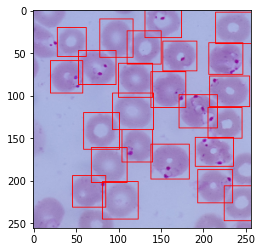

In [113]:
img = cv2.imread(imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]], cv2.IMREAD_COLOR)
list_bbxs = dict_bbxs[imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]]
img_with_box = bbv.draw_multiple_rectangles(img, [box.tolist()[:4] for box in list_bbxs], bbox_color = (255, 0, 0), thickness=1)
plt.imshow(img_with_box)

In [114]:
with open('../data/pickled/imgs_name.pkl', 'wb') as handle:
    pickle.dump(imgs_name, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickled/true_boxes.pkl', 'wb') as handle:
    pickle.dump(true_boxes, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickled/dict_bbxs.pkl', 'wb') as handle:
    pickle.dump(dict_bbxs, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Polygon to rectangle

In [115]:
filename =  'IMG_20150621_112043'
df_file = df[df['filename'] == filename]
df_file['position'].iloc[-1]

[(4166, 1704),
 (4176, 1688),
 (4184, 1664),
 (4195, 1647),
 (4230, 1633),
 (4272, 1631),
 (4309, 1644),
 (4342, 1679),
 (4341, 1709),
 (4326, 1733),
 (4299, 1758),
 (4265, 1758),
 (4233, 1750),
 (4204, 1735),
 (4174, 1718),
 (4162, 1714)]

In [116]:
rect = df_file['bbx']

In [117]:
df_file['bbx'].tolist()

[[3575, 1304, 3727, 1432],
 [1441, 1202, 1568, 1307],
 [2856, 1398, 2960, 1541],
 [2982, 1460, 3091, 1578],
 [3043, 1651, 3169, 1788],
 [2170, 1937, 2341, 2050],
 [2073, 1836, 2218, 1965],
 [1900, 1873, 2026, 1978],
 [1942, 2102, 2059, 2227],
 [1662, 1906, 1798, 2017],
 [1555, 1781, 1680, 1936],
 [1836, 1731, 2003, 1868],
 [2180, 1712, 2317, 1838],
 [2037, 1745, 2183, 1828],
 [1972, 1613, 2122, 1762],
 [1758, 1743, 1863, 1879],
 [1631, 2139, 1762, 2279],
 [1676, 2264, 1812, 2381],
 [2105, 2169, 2248, 2266],
 [2171, 2075, 2309, 2190],
 [2314, 1846, 2472, 1983],
 [2492, 1789, 2629, 1917],
 [2443, 1567, 2564, 1682],
 [2269, 1504, 2403, 1653],
 [2104, 1636, 2228, 1738],
 [2105, 1531, 2260, 1640],
 [2005, 1454, 2120, 1564],
 [1878, 1525, 2013, 1638],
 [1779, 1612, 1903, 1723],
 [1626, 1601, 1764, 1747],
 [1681, 1476, 1829, 1601],
 [1690, 1362, 1828, 1490],
 [1783, 1320, 1913, 1467],
 [1839, 1280, 1987, 1420],
 [1965, 1267, 2104, 1410],
 [2130, 1385, 2286, 1518],
 [2259, 1309, 2388, 1429],
 

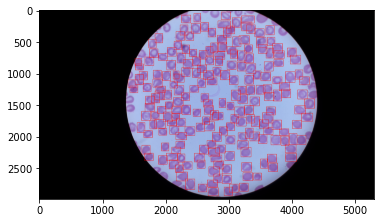

In [118]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
img_with_box = bbv.draw_multiple_rectangles(img, df_file['bbx'].tolist(), bbox_color = (255, 0, 0), thickness=3)
plt.imshow(img_with_box)

# Convert to YOLO format

In [3]:
with open('../data/pickled/imgs_name.pkl', 'rb') as handle:
    imgs_name = pickle.load(handle)
with open('../data/pickled/true_boxes.pkl', 'rb') as handle:
    true_boxes = pickle.load(handle)
with open('../data/pickled/dict_bbxs.pkl', 'rb') as handle:
    dict_bbxs = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: '../data/pickled/imgs_name.pkl'